# Coursework 2 A

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework2.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.


In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return optimiser, stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

In [64]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import DropoutLayer, RadialBasisFunctionLayer,  BatchNormalizationLayer

from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule, AdamLearningRule
from mlp.optimisers import Optimiser
from mlp.penalty import L1Penalty, L2Penalty
from collections import defaultdict, OrderedDict
import logging
import pickle
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the EMNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

['inputs', 'targets']
['inputs', 'targets']
['inputs', 'targets']


In [65]:
# save and present the data
from collections import defaultdict
save_stats= defaultdict()
def save_and_present(experiment, stats, parameter):
    
    # save the model to disk
    filename = experiment +'.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    np.savetxt(experiment +'.csv', stats, delimiter=',')

    error_valid= stats[1:, keys['error(valid)']]
    error_train= stats[1:, keys['error(train)']]
    acc_valid = stats[1:, keys['acc(valid)']]

    file = open(experiment+'_'+str(parameter)+'.txt','w')
    
    overfitting = error_valid-error_train
    file.write('Experiment '+experiment+' best acc at Epoch={} by parameter={}\n'.
          format(np.argmax(acc_valid)+1, parameter))
    file.write('error(train)= {}, error(valid)={}, \n error gap = {},  acc(valid)={}\n'.
          format(error_train[np.argmax(acc_valid)],error_valid[np.argmax(acc_valid)],overfitting[np.argmax(acc_valid)], max(acc_valid)))
    file.write('Smallest error gap(after best acc epoch) = {} at Epoch={}'.
          format(min(overfitting[np.argmax(acc_valid):]),np.argmin(overfitting[np.argmax(acc_valid):])+np.argmax(acc_valid)+1))
    print('Experiment '+experiment+' best acc at Epoch={} by parameter={}\n'.
          format(np.argmax(acc_valid)+1, parameter))
    print('error(train)= {}, error(valid)={}, \n error gap = {},  acc(valid)={}\n'.
          format(error_train[np.argmax(acc_valid)],error_valid[np.argmax(acc_valid)],overfitting[np.argmax(acc_valid)], max(acc_valid)))
    print('Smallest error gap(after best acc epoch) = {} at Epoch={}'.
          format(min(overfitting[np.argmax(acc_valid):]),np.argmin(overfitting[np.argmax(acc_valid):])+np.argmax(acc_valid)+1))

################################################################################
# prediction on test data
def prediction(filename, test_data, label='test', error = CrossEntropySoftmaxError()):
    ''' Load the model from file and predict on the test set, 
    prediction(experiment +'.sav', test_data)'''
    # load the model from disk
    loaded_model = pickle.load(open(filename, 'rb'))
    
    data_monitors = OrderedDict([('error', error)])
    data_monitors.update({'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()})
    data_mon_vals = OrderedDict([(key + label, 0.) for key
                                             in data_monitors.keys()])
    for inputs_batch, targets_batch in test_data:
        activations = loaded_model.fprop(inputs_batch, evaluation=True)
        
        for key, data_monitor in data_monitors.items():
            data_mon_vals[key + label] += data_monitor(
                            activations[-1], targets_batch)
    for key, data_monitor in data_monitors.items():
        data_mon_vals[key + label] /= test_data.num_batches
    print('Error:    ' + str(data_mon_vals['errortest']))
    print('Accuracy: ' + str(data_mon_vals['acctest']))
    return data_mon_vals

## Perform baseline experiments
There are a lot things that could be explored including:
1. hidden unit activation functions, 
2. network architectures, 
3. training hyperparameters, 
4. **regularisation and dropout.   **

### Base line: a vanilla DNN with two relu layer

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 5.5s to complete
    error(train)=1.00e+00, acc(train)=6.97e-01, error(valid)=1.01e+00, acc(valid)=6.91e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 5.5s to complete
    error(train)=7.30e-01, acc(train)=7.75e-01, error(valid)=7.58e-01, acc(valid)=7.65e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 6.2s to complete
    error(train)=6.40e-01, acc(train)=7.92e-01, error(valid)=6.73e-01, acc(valid)=7.82e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 5.6s to complete
    error(train)=5.77e-01, acc(train)=8.14e-01, error(valid)=6.19e-01, acc(valid)=8.03e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 5.1s to complete
    error(train)=5.22e-01, acc(train)=8.30e-01, error(valid)=5.74e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 5.2s to complete
    error(train)=5.06e-01, acc(train)=8.32e-01, error(valid)=5.67e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 5.3s to complete
    error(train)=4.81e-01, acc(train)=8.37e-01, error(valid)=5.49e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 5.3s to complete
    error(train)=4.55e-01, acc(train)=8.47e-01, error(valid)=5.30e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 5.3s to complete
    error(train)=4.39e-01, acc(train)=8.51e-01, error(valid)=5.25e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 5.3s to complete
    error(train)=4.27e-01, acc(train)=8.53e-01, error(valid)=5.25e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 5.3s to complete
    error(train)=4.11e-01, acc(train)=8.60e-01, error(valid)=5.10e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 5.3s to complete
    error(train)=4.04e-01, acc(train)=8.61e-01, error(valid)=5.17e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 5.3s to complete
    error(train)=3.90e-01, acc(train)=8.63e-01, error(valid)=5.09e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 5.3s to complete
    error(train)=3.71e-01, acc(train)=8.71e-01, error(valid)=4.94e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 5.3s to complete
    error(train)=3.65e-01, acc(train)=8.73e-01, error(valid)=4.92e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 5.3s to complete
    error(train)=3.68e-01, acc(train)=8.70e-01, error(valid)=5.02e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 5.4s to complete
    error(train)=3.78e-01, acc(train)=8.64e-01, error(valid)=5.23e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 5.3s to complete
    error(train)=3.44e-01, acc(train)=8.78e-01, error(valid)=4.98e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 6.1s to complete
    error(train)=3.45e-01, acc(train)=8.78e-01, error(valid)=5.03e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 5.3s to complete
    error(train)=3.45e-01, acc(train)=8.78e-01, error(valid)=5.08e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 5.2s to complete
    error(train)=3.28e-01, acc(train)=8.83e-01, error(valid)=5.00e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 5.1s to complete
    error(train)=3.35e-01, acc(train)=8.79e-01, error(valid)=5.12e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 5.1s to complete
    error(train)=3.10e-01, acc(train)=8.89e-01, error(valid)=4.92e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 5.1s to complete
    error(train)=3.14e-01, acc(train)=8.85e-01, error(valid)=5.04e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 5.3s to complete
    error(train)=3.13e-01, acc(train)=8.86e-01, error(valid)=5.10e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 5.1s to complete
    error(train)=2.95e-01, acc(train)=8.94e-01, error(valid)=4.96e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 5.3s to complete
    error(train)=3.06e-01, acc(train)=8.88e-01, error(valid)=5.16e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 5.2s to complete
    error(train)=3.02e-01, acc(train)=8.88e-01, error(valid)=5.18e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 5.4s to complete
    error(train)=2.95e-01, acc(train)=8.91e-01, error(valid)=5.08e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 5.3s to complete
    error(train)=2.83e-01, acc(train)=8.97e-01, error(valid)=5.08e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 5.2s to complete
    error(train)=2.76e-01, acc(train)=8.99e-01, error(valid)=5.04e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 5.4s to complete
    error(train)=2.78e-01, acc(train)=8.97e-01, error(valid)=5.14e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 5.4s to complete
    error(train)=2.95e-01, acc(train)=8.88e-01, error(valid)=5.44e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 5.4s to complete
    error(train)=2.77e-01, acc(train)=8.96e-01, error(valid)=5.33e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 6.0s to complete
    error(train)=2.68e-01, acc(train)=9.01e-01, error(valid)=5.24e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 5.5s to complete
    error(train)=2.58e-01, acc(train)=9.04e-01, error(valid)=5.24e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 5.4s to complete
    error(train)=2.65e-01, acc(train)=9.01e-01, error(valid)=5.36e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 5.2s to complete
    error(train)=2.58e-01, acc(train)=9.04e-01, error(valid)=5.33e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 5.4s to complete
    error(train)=2.58e-01, acc(train)=9.05e-01, error(valid)=5.44e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 5.3s to complete
    error(train)=2.58e-01, acc(train)=9.04e-01, error(valid)=5.44e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 5.4s to complete
    error(train)=2.57e-01, acc(train)=9.05e-01, error(valid)=5.45e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 5.4s to complete
    error(train)=2.60e-01, acc(train)=9.00e-01, error(valid)=5.55e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 5.3s to complete
    error(train)=2.57e-01, acc(train)=9.02e-01, error(valid)=5.63e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 5.4s to complete
    error(train)=2.60e-01, acc(train)=9.01e-01, error(valid)=5.78e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 5.3s to complete
    error(train)=2.43e-01, acc(train)=9.07e-01, error(valid)=5.64e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 5.3s to complete
    error(train)=2.46e-01, acc(train)=9.05e-01, error(valid)=5.69e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 5.4s to complete
    error(train)=2.35e-01, acc(train)=9.11e-01, error(valid)=5.70e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 5.4s to complete
    error(train)=2.39e-01, acc(train)=9.10e-01, error(valid)=5.76e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 5.3s to complete
    error(train)=2.37e-01, acc(train)=9.11e-01, error(valid)=5.81e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 5.4s to complete
    error(train)=2.38e-01, acc(train)=9.09e-01, error(valid)=5.84e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 6.1s to complete
    error(train)=2.26e-01, acc(train)=9.15e-01, error(valid)=5.78e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 5.3s to complete
    error(train)=2.35e-01, acc(train)=9.11e-01, error(valid)=6.04e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 5.4s to complete
    error(train)=2.30e-01, acc(train)=9.12e-01, error(valid)=5.97e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 5.4s to complete
    error(train)=2.32e-01, acc(train)=9.10e-01, error(valid)=6.18e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 5.4s to complete
    error(train)=2.15e-01, acc(train)=9.18e-01, error(valid)=5.91e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 5.3s to complete
    error(train)=2.19e-01, acc(train)=9.14e-01, error(valid)=6.15e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 5.4s to complete
    error(train)=2.38e-01, acc(train)=9.08e-01, error(valid)=6.34e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 5.4s to complete
    error(train)=2.24e-01, acc(train)=9.14e-01, error(valid)=6.25e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 5.3s to complete
    error(train)=2.11e-01, acc(train)=9.18e-01, error(valid)=6.20e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 5.4s to complete
    error(train)=2.20e-01, acc(train)=9.15e-01, error(valid)=6.37e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 5.2s to complete
    error(train)=2.18e-01, acc(train)=9.15e-01, error(valid)=6.33e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 5.2s to complete
    error(train)=2.33e-01, acc(train)=9.09e-01, error(valid)=6.57e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 5.1s to complete
    error(train)=2.07e-01, acc(train)=9.21e-01, error(valid)=6.30e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 5.4s to complete
    error(train)=2.07e-01, acc(train)=9.19e-01, error(valid)=6.51e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 5.4s to complete
    error(train)=2.08e-01, acc(train)=9.19e-01, error(valid)=6.56e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 5.4s to complete
    error(train)=2.11e-01, acc(train)=9.17e-01, error(valid)=6.65e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 6.0s to complete
    error(train)=2.07e-01, acc(train)=9.19e-01, error(valid)=6.76e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 5.4s to complete
    error(train)=2.00e-01, acc(train)=9.23e-01, error(valid)=6.54e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 5.4s to complete
    error(train)=1.95e-01, acc(train)=9.24e-01, error(valid)=6.68e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 5.5s to complete
    error(train)=2.02e-01, acc(train)=9.19e-01, error(valid)=6.82e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 5.4s to complete
    error(train)=1.96e-01, acc(train)=9.23e-01, error(valid)=6.78e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 5.3s to complete
    error(train)=2.10e-01, acc(train)=9.16e-01, error(valid)=7.05e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 5.3s to complete
    error(train)=1.96e-01, acc(train)=9.24e-01, error(valid)=6.85e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 5.3s to complete
    error(train)=1.94e-01, acc(train)=9.23e-01, error(valid)=6.90e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 5.3s to complete
    error(train)=1.82e-01, acc(train)=9.29e-01, error(valid)=6.89e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 5.3s to complete
    error(train)=1.88e-01, acc(train)=9.26e-01, error(valid)=7.12e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 5.4s to complete
    error(train)=1.93e-01, acc(train)=9.24e-01, error(valid)=7.18e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 5.3s to complete
    error(train)=1.87e-01, acc(train)=9.26e-01, error(valid)=7.17e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 5.4s to complete
    error(train)=1.89e-01, acc(train)=9.24e-01, error(valid)=7.31e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 5.4s to complete
    error(train)=1.96e-01, acc(train)=9.22e-01, error(valid)=7.35e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 5.3s to complete
    error(train)=1.82e-01, acc(train)=9.28e-01, error(valid)=7.40e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 5.3s to complete
    error(train)=1.84e-01, acc(train)=9.28e-01, error(valid)=7.33e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 5.7s to complete
    error(train)=1.85e-01, acc(train)=9.27e-01, error(valid)=7.50e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 5.4s to complete
    error(train)=1.79e-01, acc(train)=9.29e-01, error(valid)=7.53e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 5.3s to complete
    error(train)=1.88e-01, acc(train)=9.25e-01, error(valid)=7.74e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 5.3s to complete
    error(train)=1.74e-01, acc(train)=9.30e-01, error(valid)=7.54e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 5.6s to complete
    error(train)=1.78e-01, acc(train)=9.29e-01, error(valid)=7.71e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 5.4s to complete
    error(train)=1.83e-01, acc(train)=9.26e-01, error(valid)=7.91e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 5.3s to complete
    error(train)=1.79e-01, acc(train)=9.29e-01, error(valid)=7.70e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 5.4s to complete
    error(train)=1.74e-01, acc(train)=9.31e-01, error(valid)=7.76e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 5.3s to complete
    error(train)=1.72e-01, acc(train)=9.31e-01, error(valid)=7.86e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 5.4s to complete
    error(train)=2.03e-01, acc(train)=9.20e-01, error(valid)=8.45e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 5.3s to complete
    error(train)=1.64e-01, acc(train)=9.34e-01, error(valid)=7.98e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 5.3s to complete
    error(train)=1.71e-01, acc(train)=9.32e-01, error(valid)=8.07e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 5.4s to complete
    error(train)=1.83e-01, acc(train)=9.27e-01, error(valid)=8.32e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 5.4s to complete
    error(train)=1.79e-01, acc(train)=9.27e-01, error(valid)=8.28e-01, acc(valid)=8.20e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 5.3s to complete
    error(train)=1.71e-01, acc(train)=9.32e-01, error(valid)=8.24e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 5.1s to complete
    error(train)=1.72e-01, acc(train)=9.30e-01, error(valid)=8.35e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 5.7s to complete
    error(train)=1.82e-01, acc(train)=9.26e-01, error(valid)=8.46e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 5.3s to complete
    error(train)=1.75e-01, acc(train)=9.30e-01, error(valid)=8.42e-01, acc(valid)=8.23e-01



Experiment Relu_x2 best acc at Epoch=31 by parameter=learning_rate

error(train)= 0.27608473558192326, error(valid)=0.5043595405031753, 
 error gap = 0.22827480492125207,  acc(valid)=0.8419620253164557

Smallest error gap(after best acc epoch) = 0.22827480492125207 at Epoch=31


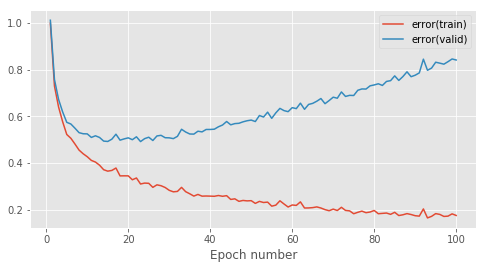

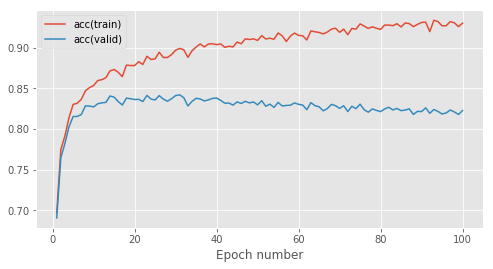

In [6]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

experiment = 'Relu_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, 'learning_rate' )

save_stats[experiment] = stats

### Base line: Regularisation
L2 Penalty with coefficient 1e-4 and 1e-3.



HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 5.6s to complete
    error(train)=9.89e-01, acc(train)=7.10e-01, error(valid)=9.99e-01, acc(valid)=7.05e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 5.7s to complete
    error(train)=7.24e-01, acc(train)=7.78e-01, error(valid)=7.46e-01, acc(valid)=7.69e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 5.7s to complete
    error(train)=6.31e-01, acc(train)=8.01e-01, error(valid)=6.57e-01, acc(valid)=7.95e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 5.7s to complete
    error(train)=5.71e-01, acc(train)=8.16e-01, error(valid)=6.12e-01, acc(valid)=8.03e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 5.7s to complete
    error(train)=5.46e-01, acc(train)=8.22e-01, error(valid)=5.94e-01, acc(valid)=8.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 5.7s to complete
    error(train)=4.99e-01, acc(train)=8.36e-01, error(valid)=5.53e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 5.7s to complete
    error(train)=4.77e-01, acc(train)=8.42e-01, error(valid)=5.42e-01, acc(valid)=8.20e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 5.7s to complete
    error(train)=4.47e-01, acc(train)=8.51e-01, error(valid)=5.19e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 5.7s to complete
    error(train)=4.52e-01, acc(train)=8.45e-01, error(valid)=5.32e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 5.7s to complete
    error(train)=4.34e-01, acc(train)=8.54e-01, error(valid)=5.19e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 5.6s to complete
    error(train)=4.19e-01, acc(train)=8.57e-01, error(valid)=5.11e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 5.8s to complete
    error(train)=4.07e-01, acc(train)=8.60e-01, error(valid)=5.02e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 5.8s to complete
    error(train)=3.95e-01, acc(train)=8.65e-01, error(valid)=4.98e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 6.0s to complete
    error(train)=4.05e-01, acc(train)=8.58e-01, error(valid)=5.19e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 5.8s to complete
    error(train)=3.97e-01, acc(train)=8.57e-01, error(valid)=5.09e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 5.8s to complete
    error(train)=3.76e-01, acc(train)=8.69e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 5.8s to complete
    error(train)=3.67e-01, acc(train)=8.71e-01, error(valid)=4.92e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 5.9s to complete
    error(train)=3.56e-01, acc(train)=8.75e-01, error(valid)=4.85e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 5.8s to complete
    error(train)=3.57e-01, acc(train)=8.72e-01, error(valid)=4.90e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 5.8s to complete
    error(train)=3.52e-01, acc(train)=8.76e-01, error(valid)=4.92e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 5.8s to complete
    error(train)=3.37e-01, acc(train)=8.80e-01, error(valid)=4.85e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 5.7s to complete
    error(train)=3.37e-01, acc(train)=8.80e-01, error(valid)=4.88e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 5.7s to complete
    error(train)=3.30e-01, acc(train)=8.83e-01, error(valid)=4.84e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 5.8s to complete
    error(train)=3.40e-01, acc(train)=8.78e-01, error(valid)=4.95e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 5.8s to complete
    error(train)=3.21e-01, acc(train)=8.85e-01, error(valid)=4.87e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 5.7s to complete
    error(train)=3.14e-01, acc(train)=8.88e-01, error(valid)=4.83e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 5.7s to complete
    error(train)=3.26e-01, acc(train)=8.84e-01, error(valid)=4.96e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 5.7s to complete
    error(train)=3.14e-01, acc(train)=8.87e-01, error(valid)=4.93e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 6.0s to complete
    error(train)=3.05e-01, acc(train)=8.90e-01, error(valid)=4.94e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 5.8s to complete
    error(train)=3.14e-01, acc(train)=8.85e-01, error(valid)=5.04e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 5.8s to complete
    error(train)=3.07e-01, acc(train)=8.90e-01, error(valid)=4.97e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 5.8s to complete
    error(train)=3.01e-01, acc(train)=8.91e-01, error(valid)=4.99e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 5.7s to complete
    error(train)=3.03e-01, acc(train)=8.89e-01, error(valid)=4.97e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 5.8s to complete
    error(train)=2.89e-01, acc(train)=8.96e-01, error(valid)=4.89e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 5.7s to complete
    error(train)=3.02e-01, acc(train)=8.88e-01, error(valid)=5.10e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 5.8s to complete
    error(train)=2.89e-01, acc(train)=8.94e-01, error(valid)=5.03e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 5.8s to complete
    error(train)=2.98e-01, acc(train)=8.89e-01, error(valid)=5.11e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 5.8s to complete
    error(train)=2.91e-01, acc(train)=8.93e-01, error(valid)=5.05e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 5.8s to complete
    error(train)=2.86e-01, acc(train)=8.94e-01, error(valid)=5.07e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 5.8s to complete
    error(train)=2.83e-01, acc(train)=8.96e-01, error(valid)=5.07e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 5.7s to complete
    error(train)=2.79e-01, acc(train)=8.98e-01, error(valid)=5.12e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 5.7s to complete
    error(train)=2.76e-01, acc(train)=8.95e-01, error(valid)=5.13e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 5.9s to complete
    error(train)=2.71e-01, acc(train)=8.99e-01, error(valid)=5.05e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 5.9s to complete
    error(train)=2.69e-01, acc(train)=9.00e-01, error(valid)=5.08e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 5.9s to complete
    error(train)=2.64e-01, acc(train)=9.02e-01, error(valid)=5.08e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 5.8s to complete
    error(train)=2.65e-01, acc(train)=9.02e-01, error(valid)=5.10e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 5.9s to complete
    error(train)=2.65e-01, acc(train)=9.02e-01, error(valid)=5.20e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 5.7s to complete
    error(train)=2.61e-01, acc(train)=9.01e-01, error(valid)=5.14e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 5.8s to complete
    error(train)=2.61e-01, acc(train)=9.03e-01, error(valid)=5.20e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 5.8s to complete
    error(train)=2.57e-01, acc(train)=9.04e-01, error(valid)=5.16e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 5.8s to complete
    error(train)=2.58e-01, acc(train)=9.05e-01, error(valid)=5.24e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 5.8s to complete
    error(train)=2.66e-01, acc(train)=9.00e-01, error(valid)=5.30e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 5.8s to complete
    error(train)=2.53e-01, acc(train)=9.06e-01, error(valid)=5.22e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 5.8s to complete
    error(train)=2.60e-01, acc(train)=9.02e-01, error(valid)=5.26e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 5.8s to complete
    error(train)=2.42e-01, acc(train)=9.11e-01, error(valid)=5.20e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 5.8s to complete
    error(train)=2.54e-01, acc(train)=9.05e-01, error(valid)=5.36e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 5.9s to complete
    error(train)=2.56e-01, acc(train)=9.05e-01, error(valid)=5.35e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 5.9s to complete
    error(train)=2.44e-01, acc(train)=9.07e-01, error(valid)=5.25e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 6.0s to complete
    error(train)=2.46e-01, acc(train)=9.08e-01, error(valid)=5.40e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 5.9s to complete
    error(train)=2.29e-01, acc(train)=9.15e-01, error(valid)=5.18e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 5.8s to complete
    error(train)=2.42e-01, acc(train)=9.09e-01, error(valid)=5.32e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 5.8s to complete
    error(train)=2.44e-01, acc(train)=9.08e-01, error(valid)=5.40e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 5.9s to complete
    error(train)=2.43e-01, acc(train)=9.09e-01, error(valid)=5.47e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 5.8s to complete
    error(train)=2.38e-01, acc(train)=9.10e-01, error(valid)=5.38e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 5.9s to complete
    error(train)=2.28e-01, acc(train)=9.15e-01, error(valid)=5.36e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 5.9s to complete
    error(train)=2.34e-01, acc(train)=9.12e-01, error(valid)=5.38e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 5.8s to complete
    error(train)=2.29e-01, acc(train)=9.13e-01, error(valid)=5.42e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 5.8s to complete
    error(train)=2.35e-01, acc(train)=9.12e-01, error(valid)=5.52e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 5.8s to complete
    error(train)=2.31e-01, acc(train)=9.13e-01, error(valid)=5.49e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 5.9s to complete
    error(train)=2.27e-01, acc(train)=9.15e-01, error(valid)=5.46e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 6.0s to complete
    error(train)=2.23e-01, acc(train)=9.16e-01, error(valid)=5.45e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 5.9s to complete
    error(train)=2.33e-01, acc(train)=9.11e-01, error(valid)=5.58e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 6.2s to complete
    error(train)=2.27e-01, acc(train)=9.13e-01, error(valid)=5.58e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 6.0s to complete
    error(train)=2.29e-01, acc(train)=9.13e-01, error(valid)=5.61e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 5.9s to complete
    error(train)=2.34e-01, acc(train)=9.11e-01, error(valid)=5.70e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 6.0s to complete
    error(train)=2.18e-01, acc(train)=9.18e-01, error(valid)=5.54e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 6.0s to complete
    error(train)=2.16e-01, acc(train)=9.19e-01, error(valid)=5.48e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 6.1s to complete
    error(train)=2.14e-01, acc(train)=9.21e-01, error(valid)=5.50e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 5.9s to complete
    error(train)=2.12e-01, acc(train)=9.21e-01, error(valid)=5.51e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 6.0s to complete
    error(train)=2.22e-01, acc(train)=9.16e-01, error(valid)=5.63e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 6.0s to complete
    error(train)=2.25e-01, acc(train)=9.14e-01, error(valid)=5.70e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 6.1s to complete
    error(train)=2.21e-01, acc(train)=9.16e-01, error(valid)=5.65e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 6.0s to complete
    error(train)=2.16e-01, acc(train)=9.19e-01, error(valid)=5.69e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 6.0s to complete
    error(train)=2.12e-01, acc(train)=9.20e-01, error(valid)=5.66e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 6.0s to complete
    error(train)=2.05e-01, acc(train)=9.24e-01, error(valid)=5.61e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 6.1s to complete
    error(train)=2.10e-01, acc(train)=9.20e-01, error(valid)=5.64e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 6.0s to complete
    error(train)=2.20e-01, acc(train)=9.16e-01, error(valid)=5.81e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 6.3s to complete
    error(train)=2.21e-01, acc(train)=9.17e-01, error(valid)=5.90e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 6.0s to complete
    error(train)=2.13e-01, acc(train)=9.19e-01, error(valid)=5.71e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 5.9s to complete
    error(train)=2.10e-01, acc(train)=9.21e-01, error(valid)=5.77e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 5.9s to complete
    error(train)=2.14e-01, acc(train)=9.14e-01, error(valid)=5.79e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 6.0s to complete
    error(train)=2.23e-01, acc(train)=9.15e-01, error(valid)=5.95e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 5.9s to complete
    error(train)=2.03e-01, acc(train)=9.24e-01, error(valid)=5.71e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 5.9s to complete
    error(train)=2.14e-01, acc(train)=9.19e-01, error(valid)=5.87e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 6.0s to complete
    error(train)=2.01e-01, acc(train)=9.23e-01, error(valid)=5.70e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 5.9s to complete
    error(train)=2.12e-01, acc(train)=9.18e-01, error(valid)=5.82e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 6.0s to complete
    error(train)=2.00e-01, acc(train)=9.25e-01, error(valid)=5.83e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 6.0s to complete
    error(train)=2.05e-01, acc(train)=9.23e-01, error(valid)=5.92e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 6.0s to complete
    error(train)=1.95e-01, acc(train)=9.27e-01, error(valid)=5.80e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 5.9s to complete
    error(train)=1.92e-01, acc(train)=9.29e-01, error(valid)=5.80e-01, acc(valid)=8.31e-01



Experiment Relu_L2Penal_1e-4_x2 best acc at Epoch=34 by parameter=0.0001

error(train)= 0.28895769015035944, error(valid)=0.48875926719334734, 
 error gap = 0.1998015770429879,  acc(valid)=0.8435443037974681

Smallest error gap(after best acc epoch) = 0.1998015770429879 at Epoch=34


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 6.2s to complete
    error(train)=9.96e-01, acc(train)=7.11e-01, error(valid)=1.01e+00, acc(valid)=7.05e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 6.1s to complete
    error(train)=7.77e-01, acc(train)=7.64e-01, error(valid)=7.95e-01, acc(valid)=7.58e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 5.9s to complete
    error(train)=6.80e-01, acc(train)=7.89e-01, error(valid)=7.06e-01, acc(valid)=7.79e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 5.7s to complete
    error(train)=6.18e-01, acc(train)=8.03e-01, error(valid)=6.45e-01, acc(valid)=7.96e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 5.7s to complete
    error(train)=5.81e-01, acc(train)=8.15e-01, error(valid)=6.17e-01, acc(valid)=8.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 5.8s to complete
    error(train)=5.60e-01, acc(train)=8.16e-01, error(valid)=5.99e-01, acc(valid)=8.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 5.7s to complete
    error(train)=5.30e-01, acc(train)=8.28e-01, error(valid)=5.68e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 5.8s to complete
    error(train)=5.31e-01, acc(train)=8.23e-01, error(valid)=5.72e-01, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 5.7s to complete
    error(train)=5.12e-01, acc(train)=8.35e-01, error(valid)=5.55e-01, acc(valid)=8.20e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 5.8s to complete
    error(train)=4.87e-01, acc(train)=8.43e-01, error(valid)=5.29e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 5.8s to complete
    error(train)=4.86e-01, acc(train)=8.40e-01, error(valid)=5.33e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 5.9s to complete
    error(train)=4.79e-01, acc(train)=8.44e-01, error(valid)=5.29e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 5.9s to complete
    error(train)=4.66e-01, acc(train)=8.49e-01, error(valid)=5.16e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 5.7s to complete
    error(train)=4.78e-01, acc(train)=8.43e-01, error(valid)=5.23e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 5.8s to complete
    error(train)=4.61e-01, acc(train)=8.48e-01, error(valid)=5.11e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 5.8s to complete
    error(train)=4.48e-01, acc(train)=8.53e-01, error(valid)=5.00e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 6.0s to complete
    error(train)=4.44e-01, acc(train)=8.55e-01, error(valid)=4.98e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 6.0s to complete
    error(train)=4.84e-01, acc(train)=8.33e-01, error(valid)=5.38e-01, acc(valid)=8.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 5.8s to complete
    error(train)=4.46e-01, acc(train)=8.50e-01, error(valid)=4.97e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 5.8s to complete
    error(train)=4.43e-01, acc(train)=8.53e-01, error(valid)=4.97e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 5.7s to complete
    error(train)=4.38e-01, acc(train)=8.55e-01, error(valid)=4.94e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 5.9s to complete
    error(train)=4.31e-01, acc(train)=8.58e-01, error(valid)=4.87e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 6.0s to complete
    error(train)=4.26e-01, acc(train)=8.59e-01, error(valid)=4.81e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 5.8s to complete
    error(train)=4.41e-01, acc(train)=8.51e-01, error(valid)=5.00e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 5.8s to complete
    error(train)=4.24e-01, acc(train)=8.60e-01, error(valid)=4.81e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 5.7s to complete
    error(train)=4.19e-01, acc(train)=8.60e-01, error(valid)=4.77e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 5.8s to complete
    error(train)=4.20e-01, acc(train)=8.61e-01, error(valid)=4.81e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 5.9s to complete
    error(train)=4.36e-01, acc(train)=8.54e-01, error(valid)=4.95e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 5.9s to complete
    error(train)=4.29e-01, acc(train)=8.55e-01, error(valid)=4.85e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 5.9s to complete
    error(train)=4.29e-01, acc(train)=8.57e-01, error(valid)=4.89e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 5.9s to complete
    error(train)=4.28e-01, acc(train)=8.57e-01, error(valid)=4.86e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 6.1s to complete
    error(train)=4.18e-01, acc(train)=8.59e-01, error(valid)=4.81e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 5.9s to complete
    error(train)=4.10e-01, acc(train)=8.64e-01, error(valid)=4.71e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 5.8s to complete
    error(train)=4.11e-01, acc(train)=8.64e-01, error(valid)=4.72e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 5.8s to complete
    error(train)=4.05e-01, acc(train)=8.66e-01, error(valid)=4.65e-01, acc(valid)=8.47e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 5.9s to complete
    error(train)=4.10e-01, acc(train)=8.65e-01, error(valid)=4.71e-01, acc(valid)=8.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 6.0s to complete
    error(train)=4.10e-01, acc(train)=8.63e-01, error(valid)=4.70e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 6.0s to complete
    error(train)=4.14e-01, acc(train)=8.60e-01, error(valid)=4.75e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 5.9s to complete
    error(train)=4.03e-01, acc(train)=8.64e-01, error(valid)=4.65e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 5.8s to complete
    error(train)=4.02e-01, acc(train)=8.67e-01, error(valid)=4.66e-01, acc(valid)=8.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 5.7s to complete
    error(train)=4.10e-01, acc(train)=8.62e-01, error(valid)=4.72e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 5.8s to complete
    error(train)=4.00e-01, acc(train)=8.65e-01, error(valid)=4.64e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 5.8s to complete
    error(train)=4.04e-01, acc(train)=8.65e-01, error(valid)=4.68e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 5.8s to complete
    error(train)=3.98e-01, acc(train)=8.67e-01, error(valid)=4.63e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 5.8s to complete
    error(train)=4.02e-01, acc(train)=8.65e-01, error(valid)=4.65e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 5.7s to complete
    error(train)=4.03e-01, acc(train)=8.65e-01, error(valid)=4.63e-01, acc(valid)=8.48e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 6.0s to complete
    error(train)=4.03e-01, acc(train)=8.64e-01, error(valid)=4.70e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 6.0s to complete
    error(train)=4.03e-01, acc(train)=8.65e-01, error(valid)=4.69e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 5.8s to complete
    error(train)=3.99e-01, acc(train)=8.68e-01, error(valid)=4.64e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 5.8s to complete
    error(train)=4.07e-01, acc(train)=8.64e-01, error(valid)=4.70e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 5.9s to complete
    error(train)=4.01e-01, acc(train)=8.65e-01, error(valid)=4.68e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 5.7s to complete
    error(train)=3.97e-01, acc(train)=8.67e-01, error(valid)=4.63e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 5.8s to complete
    error(train)=3.96e-01, acc(train)=8.68e-01, error(valid)=4.61e-01, acc(valid)=8.46e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 5.8s to complete
    error(train)=3.99e-01, acc(train)=8.68e-01, error(valid)=4.65e-01, acc(valid)=8.46e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 5.8s to complete
    error(train)=4.03e-01, acc(train)=8.68e-01, error(valid)=4.67e-01, acc(valid)=8.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 6.0s to complete
    error(train)=3.94e-01, acc(train)=8.70e-01, error(valid)=4.57e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 5.9s to complete
    error(train)=3.93e-01, acc(train)=8.71e-01, error(valid)=4.58e-01, acc(valid)=8.48e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 5.9s to complete
    error(train)=3.90e-01, acc(train)=8.71e-01, error(valid)=4.53e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 5.9s to complete
    error(train)=3.92e-01, acc(train)=8.65e-01, error(valid)=4.56e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 6.0s to complete
    error(train)=3.89e-01, acc(train)=8.71e-01, error(valid)=4.53e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 6.1s to complete
    error(train)=3.93e-01, acc(train)=8.68e-01, error(valid)=4.57e-01, acc(valid)=8.46e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 6.8s to complete
    error(train)=3.84e-01, acc(train)=8.74e-01, error(valid)=4.50e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 5.7s to complete
    error(train)=3.99e-01, acc(train)=8.65e-01, error(valid)=4.63e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 6.3s to complete
    error(train)=3.96e-01, acc(train)=8.66e-01, error(valid)=4.62e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 6.0s to complete
    error(train)=3.95e-01, acc(train)=8.70e-01, error(valid)=4.59e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 6.1s to complete
    error(train)=3.93e-01, acc(train)=8.68e-01, error(valid)=4.60e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 6.3s to complete
    error(train)=4.00e-01, acc(train)=8.67e-01, error(valid)=4.66e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 5.7s to complete
    error(train)=3.83e-01, acc(train)=8.73e-01, error(valid)=4.48e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 6.1s to complete
    error(train)=3.90e-01, acc(train)=8.70e-01, error(valid)=4.58e-01, acc(valid)=8.48e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 6.3s to complete
    error(train)=3.93e-01, acc(train)=8.65e-01, error(valid)=4.58e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 5.9s to complete
    error(train)=3.84e-01, acc(train)=8.72e-01, error(valid)=4.48e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 6.1s to complete
    error(train)=3.87e-01, acc(train)=8.71e-01, error(valid)=4.51e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 6.2s to complete
    error(train)=3.88e-01, acc(train)=8.72e-01, error(valid)=4.54e-01, acc(valid)=8.47e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 5.9s to complete
    error(train)=3.95e-01, acc(train)=8.70e-01, error(valid)=4.63e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 6.0s to complete
    error(train)=3.98e-01, acc(train)=8.67e-01, error(valid)=4.61e-01, acc(valid)=8.46e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 6.5s to complete
    error(train)=3.83e-01, acc(train)=8.73e-01, error(valid)=4.51e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 6.1s to complete
    error(train)=3.91e-01, acc(train)=8.69e-01, error(valid)=4.57e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 6.0s to complete
    error(train)=3.86e-01, acc(train)=8.71e-01, error(valid)=4.54e-01, acc(valid)=8.47e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 6.4s to complete
    error(train)=3.83e-01, acc(train)=8.72e-01, error(valid)=4.51e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 5.9s to complete
    error(train)=3.88e-01, acc(train)=8.71e-01, error(valid)=4.55e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 6.0s to complete
    error(train)=3.85e-01, acc(train)=8.72e-01, error(valid)=4.52e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 6.3s to complete
    error(train)=3.83e-01, acc(train)=8.72e-01, error(valid)=4.49e-01, acc(valid)=8.48e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 5.9s to complete
    error(train)=3.92e-01, acc(train)=8.69e-01, error(valid)=4.61e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 6.0s to complete
    error(train)=3.86e-01, acc(train)=8.71e-01, error(valid)=4.51e-01, acc(valid)=8.47e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 6.3s to complete
    error(train)=3.85e-01, acc(train)=8.72e-01, error(valid)=4.49e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 5.8s to complete
    error(train)=3.90e-01, acc(train)=8.68e-01, error(valid)=4.56e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 6.1s to complete
    error(train)=3.87e-01, acc(train)=8.73e-01, error(valid)=4.53e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 6.3s to complete
    error(train)=3.86e-01, acc(train)=8.68e-01, error(valid)=4.50e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 5.8s to complete
    error(train)=3.89e-01, acc(train)=8.70e-01, error(valid)=4.59e-01, acc(valid)=8.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 6.0s to complete
    error(train)=3.80e-01, acc(train)=8.74e-01, error(valid)=4.46e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 6.5s to complete
    error(train)=3.78e-01, acc(train)=8.75e-01, error(valid)=4.45e-01, acc(valid)=8.52e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 5.9s to complete
    error(train)=3.84e-01, acc(train)=8.71e-01, error(valid)=4.48e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 6.1s to complete
    error(train)=3.86e-01, acc(train)=8.70e-01, error(valid)=4.53e-01, acc(valid)=8.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 6.5s to complete
    error(train)=3.78e-01, acc(train)=8.73e-01, error(valid)=4.46e-01, acc(valid)=8.48e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 5.8s to complete
    error(train)=3.87e-01, acc(train)=8.69e-01, error(valid)=4.54e-01, acc(valid)=8.47e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 6.1s to complete
    error(train)=3.81e-01, acc(train)=8.72e-01, error(valid)=4.44e-01, acc(valid)=8.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 6.2s to complete
    error(train)=3.98e-01, acc(train)=8.64e-01, error(valid)=4.66e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 5.8s to complete
    error(train)=3.81e-01, acc(train)=8.74e-01, error(valid)=4.47e-01, acc(valid)=8.51e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 6.0s to complete
    error(train)=3.82e-01, acc(train)=8.73e-01, error(valid)=4.52e-01, acc(valid)=8.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 6.2s to complete
    error(train)=3.84e-01, acc(train)=8.70e-01, error(valid)=4.48e-01, acc(valid)=8.48e-01



Experiment Relu_L2Penal_1e-3_x2 best acc at Epoch=91 by parameter=0.001

error(train)= 0.3782429704411231, error(valid)=0.44511884642196003, 
 error gap = 0.06687587598083694,  acc(valid)=0.8522151898734176

Smallest error gap(after best acc epoch) = 0.06364393859290612 at Epoch=96


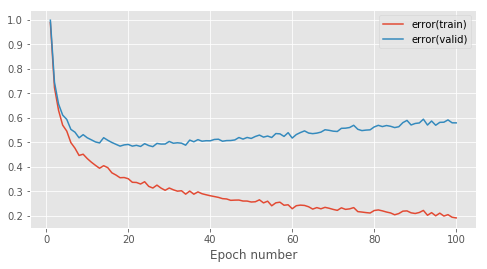

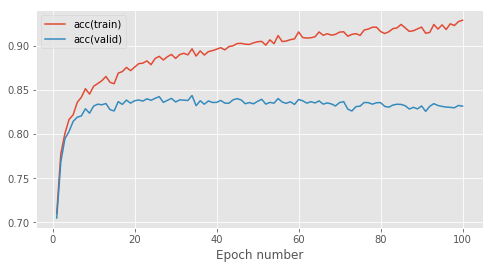

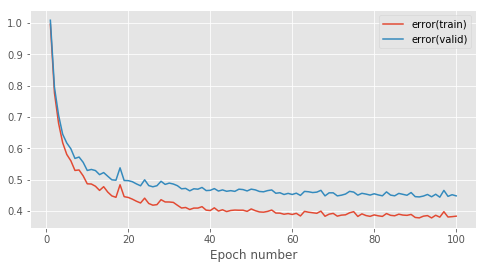

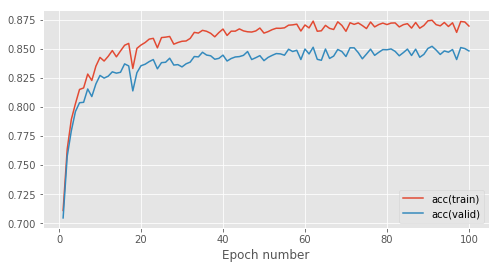

In [7]:
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser
from mlp.penalty import L1Penalty, L2Penalty

# to ensure reproducibility of results
rng.seed(seed)
#################################################################################################################
#setup hyperparameters
for experiment, penalty in zip(['Relu_L2Penal_1e-4_x2','Relu_L2Penal_1e-3_x2'], [1e-4, 1e-3]):
    
    weights_penalty = L2Penalty(penalty)
    learning_rate = 0.1
    num_epochs = 100
    stats_interval = 1
    input_dim, output_dim, hidden_dim = 784, 47, 100

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty), 
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty)
    ])

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    fig_1.savefig(experiment +'_error.pdf'.format(penalty))
    fig_2.savefig(experiment +'_accuracy.pdf'.format(penalty))

    save_and_present(experiment, stats, penalty)

    save_stats[experiment] = stats

### Baseline: Dropout

In [ ]:
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import DropoutLayer, RadialBasisFunctionLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)

#setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100
for incl_prob_0, experiment in zip([0.8,0.9],['Drop0.2', 'Drop0.1']):
    ##########################################################
    # Use p = 0.5 in hidden layers and 0.8 in the input layer.
    #incl_prob_0 =0.8
    incl_prob = 0.5
    ##########################################################
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
        DropoutLayer(rng, incl_prob_0),
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        DropoutLayer(rng, incl_prob),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        DropoutLayer(rng, incl_prob),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    #experiment = 'Drop_x2'

    optimiser, stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
    fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
    fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

    save_and_present(experiment, stats, 'learning_rate' )

    save_stats[experiment] = stats

### Plot baseline

In [44]:


#save_stats[ 'RMSProp_x2'] =save_stats[ 'RMSProp_hidden100_x2']
save_stats.keys()

dict_keys(['BN_x7', 'Re_x7', 'Relu_L2Penal_1e-4_x2', 'Relu_L2Penal_1e-3_x2', 'Drop_x2', 'Relu_x2', 'BatchNorm_sgd_x2', 'RMSProp_hidden100_x2', 'Adam_hidden100_x2'])

D:\Anaconda3\envs\mlp\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


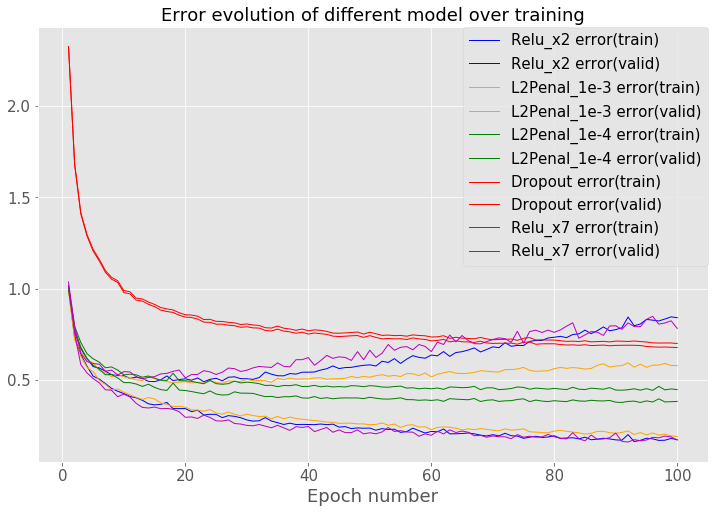

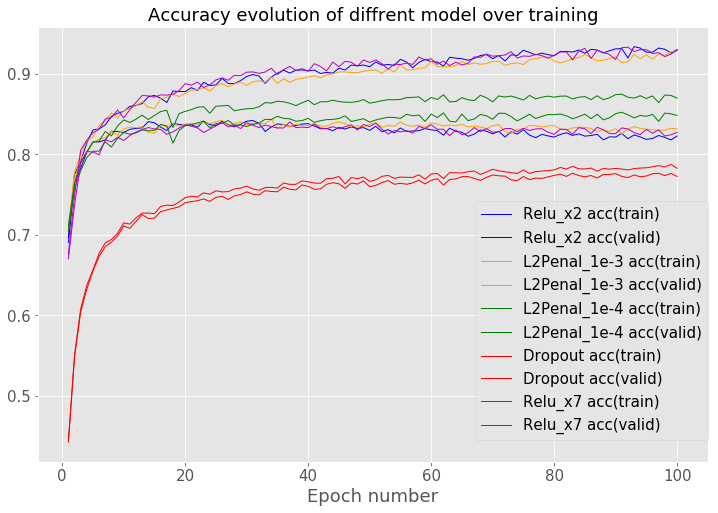

In [48]:
# Plot comparison
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
######################################################################################################
color = ['b', 'orange', 'g', 'r', 'm', 'gray', 'y',] 

experiments = ('Relu_x2', 'Relu_L2Penal_1e-4_x2', 'Relu_L2Penal_1e-3_x2', 'Drop_x2' , 'Re_x7' )

list_name = ( 'Relu_x2', 'L2Penal_1e-3', 'L2Penal_1e-4','Dropout', 'Relu_x7')

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(12 , 8))
ax_1 = fig_1.add_subplot(111)

for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(list_name[i]+' '+k), color=color[i], linewidth= 1)
ax_1.legend(bbox_to_anchor=(1., 1), loc=0, borderaxespad=0.)
ax_1.set_xlabel('Epoch number')
plt.title('Error evolution of different model over training',fontsize=18)

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(12,8))
ax_2 = fig_2.add_subplot(111)        
for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(list_name[i]+' '+k), color=color[i], linewidth= 1)

ax_2.legend(bbox_to_anchor=(1., 0.6), loc=0, borderaxespad=0.)
ax_2.set_xlabel('Epoch number')
plt.title('Accuracy evolution of diffrent model over training',fontsize=18)

fig_1.savefig('Error_baseline.pdf',bbox_inches = "tight")
fig_2.savefig('Accuracy_baseline.pdf',bbox_inches = "tight" )

## Learning rule
Here we set the num_epochs = 50, and set the learning_rate=0.001, as these learning rules learns much faster.
If a higher learning_rate is provided, learning will diverge.


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 5.1s to complete
    error(train)=3.81e+00, acc(train)=4.90e-02, error(valid)=3.80e+00, acc(valid)=5.11e-02


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 5.0s to complete
    error(train)=3.74e+00, acc(train)=7.66e-02, error(valid)=3.74e+00, acc(valid)=7.84e-02


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 3.7s to complete
    error(train)=3.67e+00, acc(train)=1.13e-01, error(valid)=3.67e+00, acc(valid)=1.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 4.3s to complete
    error(train)=3.59e+00, acc(train)=1.48e-01, error(valid)=3.58e+00, acc(valid)=1.51e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 4.8s to complete
    error(train)=3.48e+00, acc(train)=1.79e-01, error(valid)=3.48e+00, acc(valid)=1.84e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 4.6s to complete
    error(train)=3.36e+00, acc(train)=2.15e-01, error(valid)=3.35e+00, acc(valid)=2.20e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 4.1s to complete
    error(train)=3.21e+00, acc(train)=2.56e-01, error(valid)=3.20e+00, acc(valid)=2.59e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 3.7s to complete
    error(train)=3.04e+00, acc(train)=3.00e-01, error(valid)=3.04e+00, acc(valid)=3.02e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 3.6s to complete
    error(train)=2.87e+00, acc(train)=3.39e-01, error(valid)=2.87e+00, acc(valid)=3.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 3.7s to complete
    error(train)=2.70e+00, acc(train)=3.70e-01, error(valid)=2.70e+00, acc(valid)=3.72e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 4.3s to complete
    error(train)=2.54e+00, acc(train)=3.98e-01, error(valid)=2.53e+00, acc(valid)=4.01e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 4.1s to complete
    error(train)=2.39e+00, acc(train)=4.24e-01, error(valid)=2.38e+00, acc(valid)=4.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 4.6s to complete
    error(train)=2.25e+00, acc(train)=4.51e-01, error(valid)=2.25e+00, acc(valid)=4.50e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 3.7s to complete
    error(train)=2.13e+00, acc(train)=4.68e-01, error(valid)=2.13e+00, acc(valid)=4.69e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 3.7s to complete
    error(train)=2.03e+00, acc(train)=4.87e-01, error(valid)=2.03e+00, acc(valid)=4.87e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 4.0s to complete
    error(train)=1.95e+00, acc(train)=5.01e-01, error(valid)=1.95e+00, acc(valid)=5.01e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 4.3s to complete
    error(train)=1.87e+00, acc(train)=5.14e-01, error(valid)=1.87e+00, acc(valid)=5.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 4.0s to complete
    error(train)=1.81e+00, acc(train)=5.27e-01, error(valid)=1.81e+00, acc(valid)=5.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 6.2s to complete
    error(train)=1.76e+00, acc(train)=5.36e-01, error(valid)=1.76e+00, acc(valid)=5.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 5.5s to complete
    error(train)=1.71e+00, acc(train)=5.45e-01, error(valid)=1.71e+00, acc(valid)=5.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 4.6s to complete
    error(train)=1.67e+00, acc(train)=5.52e-01, error(valid)=1.67e+00, acc(valid)=5.51e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 4.7s to complete
    error(train)=1.63e+00, acc(train)=5.60e-01, error(valid)=1.63e+00, acc(valid)=5.59e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 4.7s to complete
    error(train)=1.60e+00, acc(train)=5.67e-01, error(valid)=1.60e+00, acc(valid)=5.64e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 4.8s to complete
    error(train)=1.57e+00, acc(train)=5.73e-01, error(valid)=1.57e+00, acc(valid)=5.69e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 5.6s to complete
    error(train)=1.55e+00, acc(train)=5.79e-01, error(valid)=1.55e+00, acc(valid)=5.75e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 6.5s to complete
    error(train)=1.53e+00, acc(train)=5.84e-01, error(valid)=1.53e+00, acc(valid)=5.80e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 6.3s to complete
    error(train)=1.50e+00, acc(train)=5.88e-01, error(valid)=1.50e+00, acc(valid)=5.84e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 5.3s to complete
    error(train)=1.49e+00, acc(train)=5.92e-01, error(valid)=1.49e+00, acc(valid)=5.88e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 4.9s to complete
    error(train)=1.47e+00, acc(train)=5.96e-01, error(valid)=1.47e+00, acc(valid)=5.92e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 4.3s to complete
    error(train)=1.45e+00, acc(train)=6.00e-01, error(valid)=1.45e+00, acc(valid)=5.95e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 4.7s to complete
    error(train)=1.44e+00, acc(train)=6.03e-01, error(valid)=1.44e+00, acc(valid)=5.98e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 4.5s to complete
    error(train)=1.42e+00, acc(train)=6.07e-01, error(valid)=1.42e+00, acc(valid)=6.01e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 4.5s to complete
    error(train)=1.41e+00, acc(train)=6.10e-01, error(valid)=1.41e+00, acc(valid)=6.05e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 4.1s to complete
    error(train)=1.39e+00, acc(train)=6.13e-01, error(valid)=1.40e+00, acc(valid)=6.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 5.9s to complete
    error(train)=1.38e+00, acc(train)=6.16e-01, error(valid)=1.38e+00, acc(valid)=6.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 4.5s to complete
    error(train)=1.37e+00, acc(train)=6.19e-01, error(valid)=1.37e+00, acc(valid)=6.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 4.6s to complete
    error(train)=1.36e+00, acc(train)=6.22e-01, error(valid)=1.36e+00, acc(valid)=6.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 6.0s to complete
    error(train)=1.35e+00, acc(train)=6.24e-01, error(valid)=1.35e+00, acc(valid)=6.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 4.8s to complete
    error(train)=1.34e+00, acc(train)=6.26e-01, error(valid)=1.34e+00, acc(valid)=6.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 5.0s to complete
    error(train)=1.33e+00, acc(train)=6.29e-01, error(valid)=1.33e+00, acc(valid)=6.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 4.5s to complete
    error(train)=1.32e+00, acc(train)=6.32e-01, error(valid)=1.32e+00, acc(valid)=6.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 4.2s to complete
    error(train)=1.31e+00, acc(train)=6.34e-01, error(valid)=1.31e+00, acc(valid)=6.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 5.2s to complete
    error(train)=1.30e+00, acc(train)=6.36e-01, error(valid)=1.30e+00, acc(valid)=6.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 4.2s to complete
    error(train)=1.29e+00, acc(train)=6.39e-01, error(valid)=1.30e+00, acc(valid)=6.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 4.2s to complete
    error(train)=1.29e+00, acc(train)=6.40e-01, error(valid)=1.29e+00, acc(valid)=6.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 4.2s to complete
    error(train)=1.28e+00, acc(train)=6.43e-01, error(valid)=1.28e+00, acc(valid)=6.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 4.2s to complete
    error(train)=1.27e+00, acc(train)=6.45e-01, error(valid)=1.27e+00, acc(valid)=6.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 4.2s to complete
    error(train)=1.26e+00, acc(train)=6.47e-01, error(valid)=1.27e+00, acc(valid)=6.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 4.1s to complete
    error(train)=1.26e+00, acc(train)=6.48e-01, error(valid)=1.26e+00, acc(valid)=6.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 4.1s to complete
    error(train)=1.25e+00, acc(train)=6.50e-01, error(valid)=1.25e+00, acc(valid)=6.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 4.6s to complete
    error(train)=1.24e+00, acc(train)=6.52e-01, error(valid)=1.25e+00, acc(valid)=6.45e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 4.2s to complete
    error(train)=1.24e+00, acc(train)=6.54e-01, error(valid)=1.24e+00, acc(valid)=6.47e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 5.7s to complete
    error(train)=1.23e+00, acc(train)=6.56e-01, error(valid)=1.23e+00, acc(valid)=6.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 4.3s to complete
    error(train)=1.22e+00, acc(train)=6.57e-01, error(valid)=1.23e+00, acc(valid)=6.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 4.8s to complete
    error(train)=1.22e+00, acc(train)=6.59e-01, error(valid)=1.22e+00, acc(valid)=6.52e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 4.6s to complete
    error(train)=1.21e+00, acc(train)=6.60e-01, error(valid)=1.21e+00, acc(valid)=6.53e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 4.5s to complete
    error(train)=1.20e+00, acc(train)=6.62e-01, error(valid)=1.21e+00, acc(valid)=6.55e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 4.4s to complete
    error(train)=1.20e+00, acc(train)=6.63e-01, error(valid)=1.20e+00, acc(valid)=6.57e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 4.6s to complete
    error(train)=1.19e+00, acc(train)=6.65e-01, error(valid)=1.20e+00, acc(valid)=6.58e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 4.4s to complete
    error(train)=1.19e+00, acc(train)=6.67e-01, error(valid)=1.19e+00, acc(valid)=6.60e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 5.5s to complete
    error(train)=1.18e+00, acc(train)=6.68e-01, error(valid)=1.19e+00, acc(valid)=6.61e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 4.5s to complete
    error(train)=1.18e+00, acc(train)=6.69e-01, error(valid)=1.18e+00, acc(valid)=6.64e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 4.4s to complete
    error(train)=1.17e+00, acc(train)=6.71e-01, error(valid)=1.18e+00, acc(valid)=6.63e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 4.2s to complete
    error(train)=1.17e+00, acc(train)=6.72e-01, error(valid)=1.17e+00, acc(valid)=6.65e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 4.1s to complete
    error(train)=1.16e+00, acc(train)=6.74e-01, error(valid)=1.17e+00, acc(valid)=6.66e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 4.4s to complete
    error(train)=1.16e+00, acc(train)=6.75e-01, error(valid)=1.16e+00, acc(valid)=6.68e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 4.4s to complete
    error(train)=1.15e+00, acc(train)=6.76e-01, error(valid)=1.16e+00, acc(valid)=6.71e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 4.3s to complete
    error(train)=1.15e+00, acc(train)=6.78e-01, error(valid)=1.15e+00, acc(valid)=6.72e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 4.2s to complete
    error(train)=1.14e+00, acc(train)=6.79e-01, error(valid)=1.15e+00, acc(valid)=6.72e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 4.1s to complete
    error(train)=1.14e+00, acc(train)=6.80e-01, error(valid)=1.14e+00, acc(valid)=6.73e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 6.0s to complete
    error(train)=1.13e+00, acc(train)=6.82e-01, error(valid)=1.14e+00, acc(valid)=6.74e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 4.4s to complete
    error(train)=1.13e+00, acc(train)=6.82e-01, error(valid)=1.13e+00, acc(valid)=6.76e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 5.6s to complete
    error(train)=1.12e+00, acc(train)=6.84e-01, error(valid)=1.13e+00, acc(valid)=6.76e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 4.6s to complete
    error(train)=1.12e+00, acc(train)=6.86e-01, error(valid)=1.12e+00, acc(valid)=6.78e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 4.3s to complete
    error(train)=1.11e+00, acc(train)=6.86e-01, error(valid)=1.12e+00, acc(valid)=6.78e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 4.2s to complete
    error(train)=1.11e+00, acc(train)=6.88e-01, error(valid)=1.12e+00, acc(valid)=6.80e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 4.2s to complete
    error(train)=1.11e+00, acc(train)=6.89e-01, error(valid)=1.11e+00, acc(valid)=6.82e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 4.4s to complete
    error(train)=1.10e+00, acc(train)=6.91e-01, error(valid)=1.11e+00, acc(valid)=6.82e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 4.2s to complete
    error(train)=1.10e+00, acc(train)=6.91e-01, error(valid)=1.10e+00, acc(valid)=6.84e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 4.2s to complete
    error(train)=1.09e+00, acc(train)=6.92e-01, error(valid)=1.10e+00, acc(valid)=6.85e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 4.3s to complete
    error(train)=1.09e+00, acc(train)=6.93e-01, error(valid)=1.10e+00, acc(valid)=6.87e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 4.1s to complete
    error(train)=1.08e+00, acc(train)=6.94e-01, error(valid)=1.09e+00, acc(valid)=6.87e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 4.5s to complete
    error(train)=1.08e+00, acc(train)=6.95e-01, error(valid)=1.09e+00, acc(valid)=6.88e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 4.3s to complete
    error(train)=1.08e+00, acc(train)=6.96e-01, error(valid)=1.08e+00, acc(valid)=6.89e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 4.3s to complete
    error(train)=1.07e+00, acc(train)=6.99e-01, error(valid)=1.08e+00, acc(valid)=6.91e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 4.4s to complete
    error(train)=1.07e+00, acc(train)=6.99e-01, error(valid)=1.08e+00, acc(valid)=6.92e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 5.1s to complete
    error(train)=1.06e+00, acc(train)=7.00e-01, error(valid)=1.07e+00, acc(valid)=6.93e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 5.6s to complete
    error(train)=1.06e+00, acc(train)=7.01e-01, error(valid)=1.07e+00, acc(valid)=6.94e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 6.2s to complete
    error(train)=1.06e+00, acc(train)=7.02e-01, error(valid)=1.06e+00, acc(valid)=6.96e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 5.6s to complete
    error(train)=1.05e+00, acc(train)=7.03e-01, error(valid)=1.06e+00, acc(valid)=6.97e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 4.5s to complete
    error(train)=1.05e+00, acc(train)=7.04e-01, error(valid)=1.06e+00, acc(valid)=6.97e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 5.9s to complete
    error(train)=1.05e+00, acc(train)=7.05e-01, error(valid)=1.05e+00, acc(valid)=6.99e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 7.4s to complete
    error(train)=1.04e+00, acc(train)=7.06e-01, error(valid)=1.05e+00, acc(valid)=6.99e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 4.8s to complete
    error(train)=1.04e+00, acc(train)=7.07e-01, error(valid)=1.05e+00, acc(valid)=7.01e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 4.6s to complete
    error(train)=1.03e+00, acc(train)=7.08e-01, error(valid)=1.04e+00, acc(valid)=7.02e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 4.5s to complete
    error(train)=1.03e+00, acc(train)=7.09e-01, error(valid)=1.04e+00, acc(valid)=7.02e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 4.4s to complete
    error(train)=1.03e+00, acc(train)=7.09e-01, error(valid)=1.04e+00, acc(valid)=7.02e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 4.5s to complete
    error(train)=1.02e+00, acc(train)=7.10e-01, error(valid)=1.03e+00, acc(valid)=7.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 4.2s to complete
    error(train)=1.02e+00, acc(train)=7.12e-01, error(valid)=1.03e+00, acc(valid)=7.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 4.2s to complete
    error(train)=1.02e+00, acc(train)=7.12e-01, error(valid)=1.03e+00, acc(valid)=7.05e-01


D:\Anaconda3\envs\mlp\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Experiment Relu_x2_lr_7.5e-4 best acc at Epoch=100 by parameter=learning_rate

error(train)= 1.0176291993441458, error(valid)=1.0271258838956256, 
 error gap = 0.009496684551479895,  acc(valid)=0.705

Smallest error gap(after best acc epoch) = 0.009496684551479895 at Epoch=100


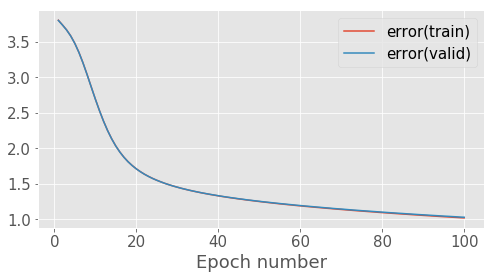

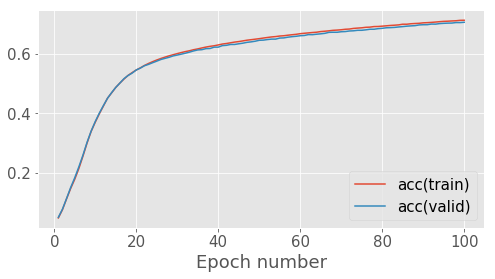

In [45]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 7.5e-4
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

experiment = 'Relu_x2_lr_7.5e-4'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, 'learning_rate' )

save_stats[experiment] = stats

### RMSProp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 7.0s to complete
    error(train)=9.22e-01, acc(train)=7.30e-01, error(valid)=9.35e-01, acc(valid)=7.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 6.5s to complete
    error(train)=6.94e-01, acc(train)=7.87e-01, error(valid)=7.20e-01, acc(valid)=7.79e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 6.6s to complete
    error(train)=6.17e-01, acc(train)=8.04e-01, error(valid)=6.53e-01, acc(valid)=7.91e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 7.6s to complete
    error(train)=5.59e-01, acc(train)=8.18e-01, error(valid)=6.03e-01, acc(valid)=8.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 6.7s to complete
    error(train)=5.21e-01, acc(train)=8.26e-01, error(valid)=5.80e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 6.7s to complete
    error(train)=4.76e-01, acc(train)=8.41e-01, error(valid)=5.45e-01, acc(valid)=8.20e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 6.6s to complete
    error(train)=4.54e-01, acc(train)=8.49e-01, error(valid)=5.35e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 6.6s to complete
    error(train)=4.37e-01, acc(train)=8.52e-01, error(valid)=5.29e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 6.6s to complete
    error(train)=4.17e-01, acc(train)=8.60e-01, error(valid)=5.21e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 6.6s to complete
    error(train)=4.12e-01, acc(train)=8.60e-01, error(valid)=5.23e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 6.7s to complete
    error(train)=3.90e-01, acc(train)=8.66e-01, error(valid)=5.17e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 6.7s to complete
    error(train)=3.85e-01, acc(train)=8.69e-01, error(valid)=5.29e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 6.5s to complete
    error(train)=3.66e-01, acc(train)=8.73e-01, error(valid)=5.09e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 6.5s to complete
    error(train)=3.74e-01, acc(train)=8.69e-01, error(valid)=5.37e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 6.5s to complete
    error(train)=3.54e-01, acc(train)=8.77e-01, error(valid)=5.24e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 6.6s to complete
    error(train)=3.43e-01, acc(train)=8.79e-01, error(valid)=5.25e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 8.1s to complete
    error(train)=3.30e-01, acc(train)=8.83e-01, error(valid)=5.24e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 6.7s to complete
    error(train)=3.37e-01, acc(train)=8.80e-01, error(valid)=5.47e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 6.7s to complete
    error(train)=3.26e-01, acc(train)=8.83e-01, error(valid)=5.36e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 6.6s to complete
    error(train)=3.14e-01, acc(train)=8.88e-01, error(valid)=5.37e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 6.6s to complete
    error(train)=3.12e-01, acc(train)=8.89e-01, error(valid)=5.45e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 6.7s to complete
    error(train)=3.08e-01, acc(train)=8.91e-01, error(valid)=5.48e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 6.6s to complete
    error(train)=3.10e-01, acc(train)=8.88e-01, error(valid)=5.56e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 6.7s to complete
    error(train)=3.09e-01, acc(train)=8.88e-01, error(valid)=5.71e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 6.6s to complete
    error(train)=3.00e-01, acc(train)=8.92e-01, error(valid)=5.75e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 6.6s to complete
    error(train)=2.93e-01, acc(train)=8.95e-01, error(valid)=5.86e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 6.7s to complete
    error(train)=2.97e-01, acc(train)=8.92e-01, error(valid)=5.92e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 6.6s to complete
    error(train)=2.83e-01, acc(train)=8.98e-01, error(valid)=5.85e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 6.7s to complete
    error(train)=2.81e-01, acc(train)=8.96e-01, error(valid)=5.96e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 8.0s to complete
    error(train)=2.82e-01, acc(train)=8.97e-01, error(valid)=6.04e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 6.6s to complete
    error(train)=2.80e-01, acc(train)=8.97e-01, error(valid)=6.11e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 6.8s to complete
    error(train)=2.63e-01, acc(train)=9.05e-01, error(valid)=6.11e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 6.8s to complete
    error(train)=2.70e-01, acc(train)=9.00e-01, error(valid)=6.14e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 6.6s to complete
    error(train)=2.76e-01, acc(train)=8.98e-01, error(valid)=6.51e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 6.6s to complete
    error(train)=2.65e-01, acc(train)=9.02e-01, error(valid)=6.44e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 6.7s to complete
    error(train)=2.67e-01, acc(train)=9.01e-01, error(valid)=6.50e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 6.6s to complete
    error(train)=2.61e-01, acc(train)=9.03e-01, error(valid)=6.62e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 6.7s to complete
    error(train)=2.50e-01, acc(train)=9.06e-01, error(valid)=6.66e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 6.7s to complete
    error(train)=2.48e-01, acc(train)=9.09e-01, error(valid)=6.74e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 6.8s to complete
    error(train)=2.54e-01, acc(train)=9.06e-01, error(valid)=6.92e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 6.7s to complete
    error(train)=2.45e-01, acc(train)=9.09e-01, error(valid)=7.03e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 6.7s to complete
    error(train)=2.49e-01, acc(train)=9.08e-01, error(valid)=6.92e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 8.0s to complete
    error(train)=2.46e-01, acc(train)=9.08e-01, error(valid)=7.25e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 7.0s to complete
    error(train)=2.44e-01, acc(train)=9.09e-01, error(valid)=7.31e-01, acc(valid)=8.20e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 6.8s to complete
    error(train)=2.39e-01, acc(train)=9.10e-01, error(valid)=7.19e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 6.8s to complete
    error(train)=2.38e-01, acc(train)=9.12e-01, error(valid)=7.30e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 6.8s to complete
    error(train)=2.30e-01, acc(train)=9.14e-01, error(valid)=7.30e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 6.8s to complete
    error(train)=2.41e-01, acc(train)=9.09e-01, error(valid)=7.65e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 6.7s to complete
    error(train)=2.52e-01, acc(train)=9.07e-01, error(valid)=8.04e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 6.6s to complete
    error(train)=2.54e-01, acc(train)=9.04e-01, error(valid)=8.00e-01, acc(valid)=8.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 6.5s to complete
    error(train)=2.32e-01, acc(train)=9.12e-01, error(valid)=7.81e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 6.5s to complete
    error(train)=2.26e-01, acc(train)=9.15e-01, error(valid)=8.10e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 6.8s to complete
    error(train)=2.36e-01, acc(train)=9.10e-01, error(valid)=8.26e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 6.4s to complete
    error(train)=2.25e-01, acc(train)=9.16e-01, error(valid)=8.11e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 6.6s to complete
    error(train)=2.24e-01, acc(train)=9.15e-01, error(valid)=8.26e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 8.2s to complete
    error(train)=2.27e-01, acc(train)=9.15e-01, error(valid)=8.23e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 6.7s to complete
    error(train)=2.30e-01, acc(train)=9.13e-01, error(valid)=8.73e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 6.8s to complete
    error(train)=2.22e-01, acc(train)=9.17e-01, error(valid)=8.73e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 6.7s to complete
    error(train)=2.16e-01, acc(train)=9.18e-01, error(valid)=8.66e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 6.6s to complete
    error(train)=2.18e-01, acc(train)=9.18e-01, error(valid)=8.89e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 6.8s to complete
    error(train)=2.23e-01, acc(train)=9.16e-01, error(valid)=8.91e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 6.8s to complete
    error(train)=2.28e-01, acc(train)=9.15e-01, error(valid)=9.43e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 6.6s to complete
    error(train)=2.13e-01, acc(train)=9.19e-01, error(valid)=8.92e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 6.8s to complete
    error(train)=2.21e-01, acc(train)=9.17e-01, error(valid)=9.37e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 6.8s to complete
    error(train)=2.21e-01, acc(train)=9.17e-01, error(valid)=9.52e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 6.6s to complete
    error(train)=2.04e-01, acc(train)=9.23e-01, error(valid)=9.18e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 6.8s to complete
    error(train)=2.10e-01, acc(train)=9.19e-01, error(valid)=9.17e-01, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 6.7s to complete
    error(train)=2.20e-01, acc(train)=9.16e-01, error(valid)=9.70e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 7.9s to complete
    error(train)=2.14e-01, acc(train)=9.19e-01, error(valid)=9.66e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 6.7s to complete
    error(train)=2.14e-01, acc(train)=9.19e-01, error(valid)=1.00e+00, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 6.6s to complete
    error(train)=2.14e-01, acc(train)=9.21e-01, error(valid)=9.96e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 6.8s to complete
    error(train)=2.11e-01, acc(train)=9.18e-01, error(valid)=9.73e-01, acc(valid)=8.06e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 6.7s to complete
    error(train)=2.08e-01, acc(train)=9.21e-01, error(valid)=1.01e+00, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 6.7s to complete
    error(train)=2.07e-01, acc(train)=9.22e-01, error(valid)=9.97e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 6.6s to complete
    error(train)=2.10e-01, acc(train)=9.20e-01, error(valid)=1.02e+00, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 6.7s to complete
    error(train)=2.14e-01, acc(train)=9.19e-01, error(valid)=1.04e+00, acc(valid)=8.07e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 6.8s to complete
    error(train)=2.14e-01, acc(train)=9.22e-01, error(valid)=1.08e+00, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 6.7s to complete
    error(train)=2.10e-01, acc(train)=9.20e-01, error(valid)=1.09e+00, acc(valid)=8.07e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 6.6s to complete
    error(train)=2.19e-01, acc(train)=9.18e-01, error(valid)=1.05e+00, acc(valid)=8.03e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 6.7s to complete
    error(train)=2.15e-01, acc(train)=9.19e-01, error(valid)=1.13e+00, acc(valid)=8.06e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 6.7s to complete
    error(train)=2.10e-01, acc(train)=9.21e-01, error(valid)=1.08e+00, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 7.6s to complete
    error(train)=2.11e-01, acc(train)=9.21e-01, error(valid)=1.12e+00, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 6.7s to complete
    error(train)=1.99e-01, acc(train)=9.24e-01, error(valid)=1.12e+00, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 6.6s to complete
    error(train)=2.08e-01, acc(train)=9.24e-01, error(valid)=1.12e+00, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 6.6s to complete
    error(train)=2.16e-01, acc(train)=9.20e-01, error(valid)=1.15e+00, acc(valid)=8.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 6.8s to complete
    error(train)=2.00e-01, acc(train)=9.24e-01, error(valid)=1.12e+00, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 6.8s to complete
    error(train)=2.10e-01, acc(train)=9.19e-01, error(valid)=1.16e+00, acc(valid)=8.00e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 6.7s to complete
    error(train)=2.05e-01, acc(train)=9.23e-01, error(valid)=1.16e+00, acc(valid)=8.01e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 7.0s to complete
    error(train)=1.96e-01, acc(train)=9.28e-01, error(valid)=1.19e+00, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 7.0s to complete
    error(train)=2.09e-01, acc(train)=9.22e-01, error(valid)=1.19e+00, acc(valid)=8.03e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 6.6s to complete
    error(train)=1.91e-01, acc(train)=9.27e-01, error(valid)=1.20e+00, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 6.6s to complete
    error(train)=2.06e-01, acc(train)=9.22e-01, error(valid)=1.17e+00, acc(valid)=8.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 6.6s to complete
    error(train)=2.10e-01, acc(train)=9.22e-01, error(valid)=1.22e+00, acc(valid)=8.03e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 6.6s to complete
    error(train)=1.97e-01, acc(train)=9.25e-01, error(valid)=1.21e+00, acc(valid)=8.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 7.3s to complete
    error(train)=1.79e-01, acc(train)=9.31e-01, error(valid)=1.20e+00, acc(valid)=8.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 6.8s to complete
    error(train)=1.91e-01, acc(train)=9.26e-01, error(valid)=1.20e+00, acc(valid)=8.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 6.7s to complete
    error(train)=2.06e-01, acc(train)=9.24e-01, error(valid)=1.29e+00, acc(valid)=8.05e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 6.7s to complete
    error(train)=1.94e-01, acc(train)=9.27e-01, error(valid)=1.29e+00, acc(valid)=8.05e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 6.7s to complete
    error(train)=1.96e-01, acc(train)=9.27e-01, error(valid)=1.26e+00, acc(valid)=8.07e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 6.6s to complete
    error(train)=2.01e-01, acc(train)=9.26e-01, error(valid)=1.32e+00, acc(valid)=8.05e-01



Experiment RMSProp_hidden100_x2 best acc at Epoch=20 by parameter=0.00075

error(train)= 0.3143963821310748, error(valid)=0.53664505146907, 
 error gap = 0.22224866933799525,  acc(valid)=0.8374683544303797

Smallest error gap(after best acc epoch) = 0.22224866933799525 at Epoch=20


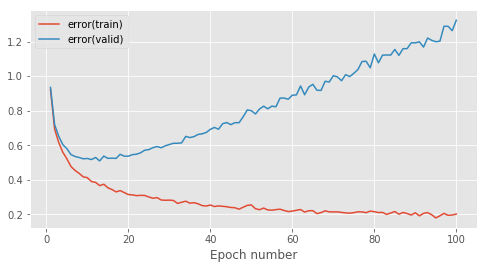

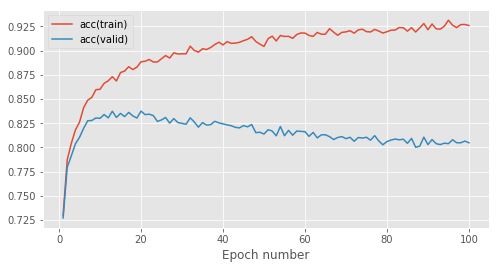

In [16]:
%load_ext autoreload
%autoreload 2
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import RMSPropLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)
#train_data.reset()
#valid_data.reset()

#setup hyperparameters
learning_rate = 7.5e-4
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = RMSPropLearningRule(learning_rate=learning_rate,)

experiment = 'RMSProp_hidden100_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

### Adam learning rules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 7.7s to complete
    error(train)=7.16e-01, acc(train)=7.79e-01, error(valid)=7.39e-01, acc(valid)=7.73e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 7.5s to complete
    error(train)=6.06e-01, acc(train)=8.08e-01, error(valid)=6.43e-01, acc(valid)=7.98e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 5.9s to complete
    error(train)=5.44e-01, acc(train)=8.24e-01, error(valid)=5.95e-01, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 6.0s to complete
    error(train)=5.12e-01, acc(train)=8.35e-01, error(valid)=5.67e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 5.9s to complete
    error(train)=4.89e-01, acc(train)=8.39e-01, error(valid)=5.58e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 5.9s to complete
    error(train)=4.64e-01, acc(train)=8.47e-01, error(valid)=5.44e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 6.4s to complete
    error(train)=4.50e-01, acc(train)=8.47e-01, error(valid)=5.37e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 6.6s to complete
    error(train)=4.21e-01, acc(train)=8.58e-01, error(valid)=5.16e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 6.6s to complete
    error(train)=4.15e-01, acc(train)=8.58e-01, error(valid)=5.21e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 6.6s to complete
    error(train)=3.99e-01, acc(train)=8.64e-01, error(valid)=5.16e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 6.6s to complete
    error(train)=3.92e-01, acc(train)=8.64e-01, error(valid)=5.12e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 7.1s to complete
    error(train)=3.81e-01, acc(train)=8.68e-01, error(valid)=5.11e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 7.3s to complete
    error(train)=3.74e-01, acc(train)=8.69e-01, error(valid)=5.12e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 8.5s to complete
    error(train)=3.57e-01, acc(train)=8.76e-01, error(valid)=5.03e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 7.3s to complete
    error(train)=3.47e-01, acc(train)=8.80e-01, error(valid)=5.02e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 7.4s to complete
    error(train)=3.43e-01, acc(train)=8.81e-01, error(valid)=5.08e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 7.6s to complete
    error(train)=3.53e-01, acc(train)=8.73e-01, error(valid)=5.26e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 7.7s to complete
    error(train)=3.34e-01, acc(train)=8.83e-01, error(valid)=5.09e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 7.9s to complete
    error(train)=3.23e-01, acc(train)=8.85e-01, error(valid)=5.13e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 8.2s to complete
    error(train)=3.24e-01, acc(train)=8.84e-01, error(valid)=5.17e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 7.6s to complete
    error(train)=3.05e-01, acc(train)=8.91e-01, error(valid)=5.10e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 7.7s to complete
    error(train)=3.17e-01, acc(train)=8.86e-01, error(valid)=5.30e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 7.9s to complete
    error(train)=3.00e-01, acc(train)=8.93e-01, error(valid)=5.16e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 7.8s to complete
    error(train)=3.04e-01, acc(train)=8.89e-01, error(valid)=5.31e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 7.5s to complete
    error(train)=2.98e-01, acc(train)=8.92e-01, error(valid)=5.34e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 8.9s to complete
    error(train)=2.87e-01, acc(train)=8.96e-01, error(valid)=5.30e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 7.8s to complete
    error(train)=2.87e-01, acc(train)=8.93e-01, error(valid)=5.39e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 7.7s to complete
    error(train)=2.84e-01, acc(train)=8.96e-01, error(valid)=5.38e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 8.3s to complete
    error(train)=2.78e-01, acc(train)=8.98e-01, error(valid)=5.48e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 7.7s to complete
    error(train)=2.81e-01, acc(train)=8.96e-01, error(valid)=5.52e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 7.9s to complete
    error(train)=2.79e-01, acc(train)=8.96e-01, error(valid)=5.53e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 8.4s to complete
    error(train)=2.79e-01, acc(train)=8.94e-01, error(valid)=5.69e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 7.9s to complete
    error(train)=2.66e-01, acc(train)=9.00e-01, error(valid)=5.63e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 7.9s to complete
    error(train)=2.53e-01, acc(train)=9.07e-01, error(valid)=5.52e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 8.3s to complete
    error(train)=2.59e-01, acc(train)=9.03e-01, error(valid)=5.69e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 7.9s to complete
    error(train)=2.55e-01, acc(train)=9.05e-01, error(valid)=5.77e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 8.5s to complete
    error(train)=2.57e-01, acc(train)=9.03e-01, error(valid)=5.83e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 7.8s to complete
    error(train)=2.61e-01, acc(train)=9.01e-01, error(valid)=6.02e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 8.0s to complete
    error(train)=2.51e-01, acc(train)=9.05e-01, error(valid)=5.95e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 8.0s to complete
    error(train)=2.42e-01, acc(train)=9.10e-01, error(valid)=5.91e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 8.0s to complete
    error(train)=2.54e-01, acc(train)=9.04e-01, error(valid)=6.21e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 8.0s to complete
    error(train)=2.37e-01, acc(train)=9.10e-01, error(valid)=6.09e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 7.9s to complete
    error(train)=2.32e-01, acc(train)=9.13e-01, error(valid)=6.02e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 7.8s to complete
    error(train)=2.30e-01, acc(train)=9.13e-01, error(valid)=6.09e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 7.8s to complete
    error(train)=2.30e-01, acc(train)=9.13e-01, error(valid)=6.21e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 7.8s to complete
    error(train)=2.27e-01, acc(train)=9.14e-01, error(valid)=6.27e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 7.9s to complete
    error(train)=2.26e-01, acc(train)=9.14e-01, error(valid)=6.35e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 7.9s to complete
    error(train)=2.26e-01, acc(train)=9.14e-01, error(valid)=6.47e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 9.3s to complete
    error(train)=2.19e-01, acc(train)=9.17e-01, error(valid)=6.45e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 7.9s to complete
    error(train)=2.24e-01, acc(train)=9.14e-01, error(valid)=6.60e-01, acc(valid)=8.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 7.9s to complete
    error(train)=2.17e-01, acc(train)=9.18e-01, error(valid)=6.58e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 8.0s to complete
    error(train)=2.31e-01, acc(train)=9.11e-01, error(valid)=6.84e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 8.1s to complete
    error(train)=2.08e-01, acc(train)=9.20e-01, error(valid)=6.65e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 7.8s to complete
    error(train)=2.14e-01, acc(train)=9.17e-01, error(valid)=6.76e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 8.0s to complete
    error(train)=2.10e-01, acc(train)=9.20e-01, error(valid)=6.81e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 8.0s to complete
    error(train)=2.08e-01, acc(train)=9.20e-01, error(valid)=6.84e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 7.9s to complete
    error(train)=2.01e-01, acc(train)=9.22e-01, error(valid)=6.86e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 8.0s to complete
    error(train)=2.05e-01, acc(train)=9.20e-01, error(valid)=7.10e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 7.9s to complete
    error(train)=2.01e-01, acc(train)=9.22e-01, error(valid)=7.07e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 8.7s to complete
    error(train)=2.00e-01, acc(train)=9.21e-01, error(valid)=7.19e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 8.1s to complete
    error(train)=1.94e-01, acc(train)=9.24e-01, error(valid)=7.15e-01, acc(valid)=8.20e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 8.1s to complete
    error(train)=1.97e-01, acc(train)=9.24e-01, error(valid)=7.21e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 7.9s to complete
    error(train)=2.04e-01, acc(train)=9.18e-01, error(valid)=7.40e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 8.1s to complete
    error(train)=1.87e-01, acc(train)=9.27e-01, error(valid)=7.28e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 7.9s to complete
    error(train)=2.01e-01, acc(train)=9.21e-01, error(valid)=7.56e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 8.1s to complete
    error(train)=1.91e-01, acc(train)=9.26e-01, error(valid)=7.48e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 8.0s to complete
    error(train)=1.93e-01, acc(train)=9.24e-01, error(valid)=7.57e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 8.0s to complete
    error(train)=1.83e-01, acc(train)=9.27e-01, error(valid)=7.65e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 8.1s to complete
    error(train)=1.90e-01, acc(train)=9.25e-01, error(valid)=7.69e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 9.1s to complete
    error(train)=1.82e-01, acc(train)=9.29e-01, error(valid)=7.90e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 8.9s to complete
    error(train)=1.81e-01, acc(train)=9.28e-01, error(valid)=7.84e-01, acc(valid)=8.19e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 9.2s to complete
    error(train)=1.83e-01, acc(train)=9.29e-01, error(valid)=7.97e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 8.7s to complete
    error(train)=1.89e-01, acc(train)=9.25e-01, error(valid)=8.14e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 8.6s to complete
    error(train)=1.83e-01, acc(train)=9.28e-01, error(valid)=8.13e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 8.7s to complete
    error(train)=1.77e-01, acc(train)=9.30e-01, error(valid)=8.13e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 8.7s to complete
    error(train)=1.73e-01, acc(train)=9.32e-01, error(valid)=8.18e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 8.7s to complete
    error(train)=1.76e-01, acc(train)=9.31e-01, error(valid)=8.22e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 8.6s to complete
    error(train)=1.76e-01, acc(train)=9.29e-01, error(valid)=8.25e-01, acc(valid)=8.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 8.7s to complete
    error(train)=1.78e-01, acc(train)=9.29e-01, error(valid)=8.40e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 8.6s to complete
    error(train)=1.81e-01, acc(train)=9.28e-01, error(valid)=8.56e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 8.6s to complete
    error(train)=1.73e-01, acc(train)=9.30e-01, error(valid)=8.64e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 9.9s to complete
    error(train)=1.65e-01, acc(train)=9.34e-01, error(valid)=8.57e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 8.8s to complete
    error(train)=1.79e-01, acc(train)=9.28e-01, error(valid)=8.96e-01, acc(valid)=8.14e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 8.7s to complete
    error(train)=1.66e-01, acc(train)=9.34e-01, error(valid)=8.81e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 8.8s to complete
    error(train)=1.65e-01, acc(train)=9.34e-01, error(valid)=8.95e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 8.7s to complete
    error(train)=1.75e-01, acc(train)=9.29e-01, error(valid)=9.13e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 8.8s to complete
    error(train)=1.65e-01, acc(train)=9.34e-01, error(valid)=9.06e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 8.8s to complete
    error(train)=1.66e-01, acc(train)=9.33e-01, error(valid)=9.07e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 8.7s to complete
    error(train)=1.63e-01, acc(train)=9.34e-01, error(valid)=9.15e-01, acc(valid)=8.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 8.8s to complete
    error(train)=1.54e-01, acc(train)=9.38e-01, error(valid)=9.12e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 8.7s to complete
    error(train)=1.58e-01, acc(train)=9.36e-01, error(valid)=9.39e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 8.7s to complete
    error(train)=1.64e-01, acc(train)=9.34e-01, error(valid)=9.44e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 9.9s to complete
    error(train)=1.56e-01, acc(train)=9.37e-01, error(valid)=9.43e-01, acc(valid)=8.16e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 8.8s to complete
    error(train)=1.64e-01, acc(train)=9.34e-01, error(valid)=9.60e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 8.7s to complete
    error(train)=1.59e-01, acc(train)=9.36e-01, error(valid)=9.63e-01, acc(valid)=8.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 8.6s to complete
    error(train)=1.57e-01, acc(train)=9.36e-01, error(valid)=9.66e-01, acc(valid)=8.09e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 8.6s to complete
    error(train)=1.53e-01, acc(train)=9.39e-01, error(valid)=9.77e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 8.5s to complete
    error(train)=1.54e-01, acc(train)=9.37e-01, error(valid)=9.78e-01, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 8.5s to complete
    error(train)=1.56e-01, acc(train)=9.37e-01, error(valid)=1.00e+00, acc(valid)=8.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 8.6s to complete
    error(train)=1.52e-01, acc(train)=9.39e-01, error(valid)=1.00e+00, acc(valid)=8.12e-01



Experiment Adam_hidden100_x2 best acc at Epoch=21 by parameter=0.00075

error(train)= 0.3054336233335715, error(valid)=0.5102946791222859, 
 error gap = 0.20486105578871439,  acc(valid)=0.8384177215189866

Smallest error gap(after best acc epoch) = 0.20486105578871439 at Epoch=21


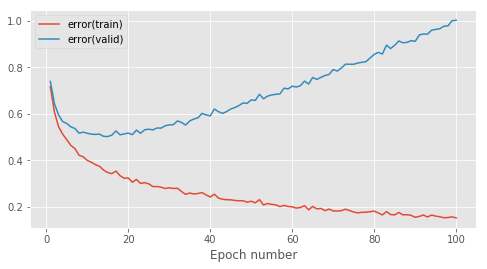

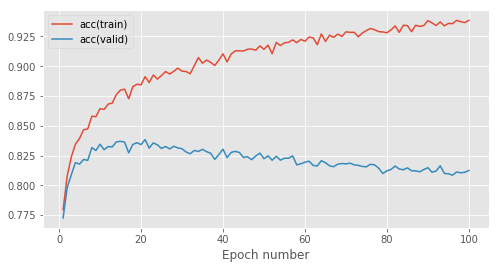

In [15]:
%load_ext autoreload
%autoreload 2
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import RMSPropLearningRule,AdamLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)

#setup hyperparameters
learning_rate = 7.5e-4
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate,)
experiment = 'Adam_hidden100_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+ '_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

### Plot learning rule

D:\Anaconda3\envs\mlp\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


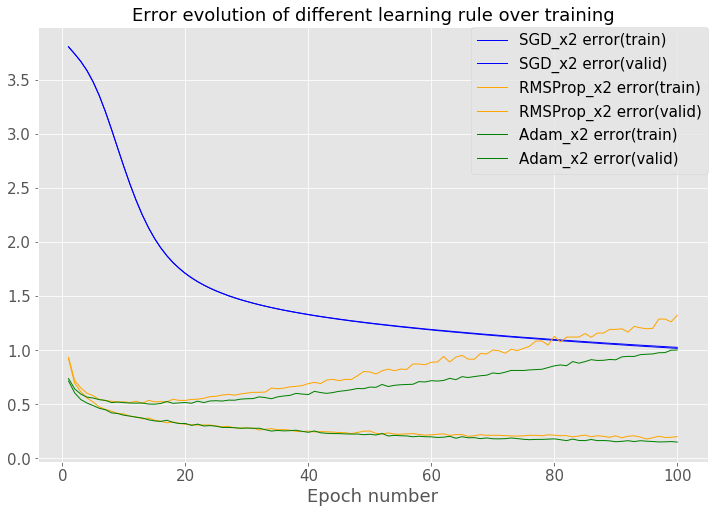

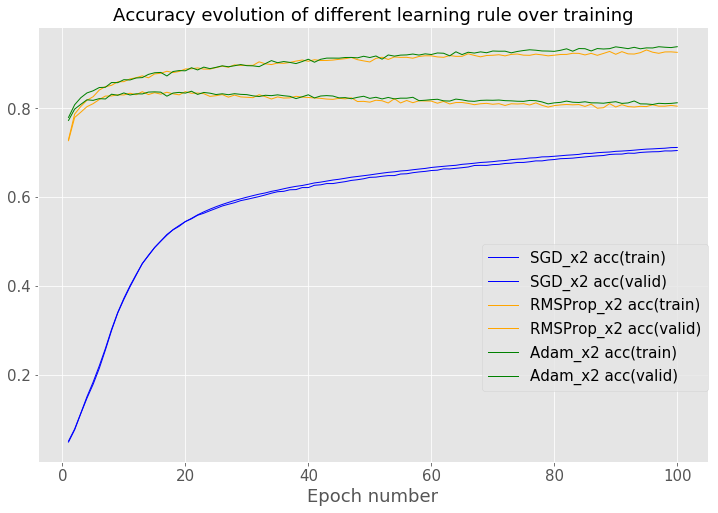

In [47]:
# Plot comparison
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
######################################################################################################
color = ['b', 'orange', 'g', 'r',  'm', 'b','y',] 
experiments = ('SGD_x2', 'RMSProp_x2', 'Adam_x2')



# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(12 , 8),facecolor='white')
ax_1 = fig_1.add_subplot(111)

for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(experiments[i]+' '+k), color = color[i], linewidth=1.)

ax_1.legend(bbox_to_anchor=(1., 1), loc=0, borderaxespad=0.)
ax_1.set_xlabel('Epoch number')
plt.title('Error evolution of different learning rule over training',fontsize=18)
        
# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(12, 8),facecolor='white')
ax_2 = fig_2.add_subplot(111)
        
for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(experiments[i]+' '+k), color = color[i], linewidth=1.)

ax_2.legend(bbox_to_anchor=(1., 0.5), loc=0, borderaxespad=0.)
ax_2.set_xlabel('Epoch number')
plt.title('Accuracy evolution of different learning rule over training',fontsize=18)

fig_1.savefig('Error_learning_rule.pdf',bbox_inches = "tight")
fig_2.savefig('Accuracy_learning_rule.pdf',bbox_inches = "tight" )

## Batch normalisation
### Batch normalisaiton before activation
As batch normalisation may help model learn faster, here we will use a higher learning rate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 7.8s to complete
    error(train)=8.46e-01, acc(train)=7.42e-01, error(valid)=8.67e-01, acc(valid)=7.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 7.6s to complete
    error(train)=6.67e-01, acc(train)=7.89e-01, error(valid)=7.01e-01, acc(valid)=7.80e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 7.7s to complete
    error(train)=5.74e-01, acc(train)=8.17e-01, error(valid)=6.18e-01, acc(valid)=8.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 8.0s to complete
    error(train)=5.30e-01, acc(train)=8.27e-01, error(valid)=5.83e-01, acc(valid)=8.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 7.8s to complete
    error(train)=5.00e-01, acc(train)=8.35e-01, error(valid)=5.63e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 7.7s to complete
    error(train)=4.75e-01, acc(train)=8.41e-01, error(valid)=5.47e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 7.7s to complete
    error(train)=4.52e-01, acc(train)=8.47e-01, error(valid)=5.30e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 7.7s to complete
    error(train)=4.32e-01, acc(train)=8.53e-01, error(valid)=5.20e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 7.7s to complete
    error(train)=4.24e-01, acc(train)=8.55e-01, error(valid)=5.12e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 7.7s to complete
    error(train)=4.11e-01, acc(train)=8.57e-01, error(valid)=5.10e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 7.6s to complete
    error(train)=3.98e-01, acc(train)=8.63e-01, error(valid)=5.03e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 7.7s to complete
    error(train)=3.84e-01, acc(train)=8.67e-01, error(valid)=4.99e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 7.7s to complete
    error(train)=3.76e-01, acc(train)=8.69e-01, error(valid)=4.88e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 7.7s to complete
    error(train)=3.73e-01, acc(train)=8.69e-01, error(valid)=4.95e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 7.7s to complete
    error(train)=3.69e-01, acc(train)=8.71e-01, error(valid)=5.02e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 8.1s to complete
    error(train)=3.77e-01, acc(train)=8.63e-01, error(valid)=5.14e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 7.8s to complete
    error(train)=3.58e-01, acc(train)=8.74e-01, error(valid)=4.95e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 7.8s to complete
    error(train)=3.45e-01, acc(train)=8.78e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 7.7s to complete
    error(train)=3.46e-01, acc(train)=8.78e-01, error(valid)=4.89e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 7.8s to complete
    error(train)=3.35e-01, acc(train)=8.82e-01, error(valid)=4.82e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 7.7s to complete
    error(train)=3.28e-01, acc(train)=8.85e-01, error(valid)=4.84e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 7.8s to complete
    error(train)=3.30e-01, acc(train)=8.82e-01, error(valid)=4.90e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 7.6s to complete
    error(train)=3.25e-01, acc(train)=8.84e-01, error(valid)=4.91e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 7.8s to complete
    error(train)=3.19e-01, acc(train)=8.86e-01, error(valid)=4.87e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 7.7s to complete
    error(train)=3.18e-01, acc(train)=8.86e-01, error(valid)=4.93e-01, acc(valid)=8.44e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 7.7s to complete
    error(train)=3.08e-01, acc(train)=8.89e-01, error(valid)=4.88e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 7.6s to complete
    error(train)=3.06e-01, acc(train)=8.90e-01, error(valid)=4.91e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 7.9s to complete
    error(train)=3.04e-01, acc(train)=8.90e-01, error(valid)=4.94e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 7.8s to complete
    error(train)=3.01e-01, acc(train)=8.91e-01, error(valid)=4.92e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 7.7s to complete
    error(train)=2.96e-01, acc(train)=8.93e-01, error(valid)=4.92e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 7.8s to complete
    error(train)=2.94e-01, acc(train)=8.95e-01, error(valid)=4.96e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 7.7s to complete
    error(train)=2.91e-01, acc(train)=8.95e-01, error(valid)=4.95e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 7.7s to complete
    error(train)=2.87e-01, acc(train)=8.97e-01, error(valid)=4.97e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 7.8s to complete
    error(train)=2.85e-01, acc(train)=8.96e-01, error(valid)=4.99e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 7.8s to complete
    error(train)=2.78e-01, acc(train)=8.99e-01, error(valid)=4.93e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 7.7s to complete
    error(train)=2.82e-01, acc(train)=8.96e-01, error(valid)=5.01e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 7.8s to complete
    error(train)=2.78e-01, acc(train)=8.97e-01, error(valid)=5.05e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 7.7s to complete
    error(train)=2.72e-01, acc(train)=9.01e-01, error(valid)=5.01e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 7.8s to complete
    error(train)=2.70e-01, acc(train)=9.01e-01, error(valid)=5.03e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 7.9s to complete
    error(train)=2.67e-01, acc(train)=9.03e-01, error(valid)=5.02e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 7.7s to complete
    error(train)=2.70e-01, acc(train)=9.01e-01, error(valid)=5.08e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 7.8s to complete
    error(train)=2.66e-01, acc(train)=9.03e-01, error(valid)=5.08e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 7.7s to complete
    error(train)=2.59e-01, acc(train)=9.05e-01, error(valid)=5.05e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 7.7s to complete
    error(train)=2.60e-01, acc(train)=9.04e-01, error(valid)=5.06e-01, acc(valid)=8.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 7.6s to complete
    error(train)=2.58e-01, acc(train)=9.04e-01, error(valid)=5.10e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 7.6s to complete
    error(train)=2.55e-01, acc(train)=9.06e-01, error(valid)=5.10e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 7.8s to complete
    error(train)=2.53e-01, acc(train)=9.06e-01, error(valid)=5.13e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 7.7s to complete
    error(train)=2.52e-01, acc(train)=9.07e-01, error(valid)=5.17e-01, acc(valid)=8.43e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 7.8s to complete
    error(train)=2.55e-01, acc(train)=9.04e-01, error(valid)=5.20e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 7.8s to complete
    error(train)=2.48e-01, acc(train)=9.07e-01, error(valid)=5.15e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 7.9s to complete
    error(train)=2.53e-01, acc(train)=9.06e-01, error(valid)=5.22e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 7.9s to complete
    error(train)=2.46e-01, acc(train)=9.09e-01, error(valid)=5.26e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 7.7s to complete
    error(train)=2.52e-01, acc(train)=9.05e-01, error(valid)=5.32e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 7.7s to complete
    error(train)=2.43e-01, acc(train)=9.09e-01, error(valid)=5.28e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 7.7s to complete
    error(train)=2.43e-01, acc(train)=9.10e-01, error(valid)=5.36e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 7.6s to complete
    error(train)=2.37e-01, acc(train)=9.12e-01, error(valid)=5.22e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 7.7s to complete
    error(train)=2.37e-01, acc(train)=9.12e-01, error(valid)=5.27e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 7.6s to complete
    error(train)=2.37e-01, acc(train)=9.12e-01, error(valid)=5.35e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 7.6s to complete
    error(train)=2.38e-01, acc(train)=9.11e-01, error(valid)=5.35e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 7.7s to complete
    error(train)=2.33e-01, acc(train)=9.12e-01, error(valid)=5.34e-01, acc(valid)=8.41e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 7.7s to complete
    error(train)=2.34e-01, acc(train)=9.12e-01, error(valid)=5.41e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 7.7s to complete
    error(train)=2.25e-01, acc(train)=9.16e-01, error(valid)=5.33e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 8.0s to complete
    error(train)=2.29e-01, acc(train)=9.15e-01, error(valid)=5.37e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 7.9s to complete
    error(train)=2.25e-01, acc(train)=9.15e-01, error(valid)=5.43e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 7.7s to complete
    error(train)=2.29e-01, acc(train)=9.14e-01, error(valid)=5.47e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 7.7s to complete
    error(train)=2.25e-01, acc(train)=9.16e-01, error(valid)=5.49e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 7.7s to complete
    error(train)=2.21e-01, acc(train)=9.19e-01, error(valid)=5.45e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 7.7s to complete
    error(train)=2.23e-01, acc(train)=9.17e-01, error(valid)=5.51e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 7.6s to complete
    error(train)=2.29e-01, acc(train)=9.13e-01, error(valid)=5.55e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 7.6s to complete
    error(train)=2.21e-01, acc(train)=9.16e-01, error(valid)=5.56e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 7.8s to complete
    error(train)=2.19e-01, acc(train)=9.17e-01, error(valid)=5.59e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 7.8s to complete
    error(train)=2.20e-01, acc(train)=9.18e-01, error(valid)=5.54e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 7.8s to complete
    error(train)=2.19e-01, acc(train)=9.20e-01, error(valid)=5.61e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 7.7s to complete
    error(train)=2.19e-01, acc(train)=9.18e-01, error(valid)=5.63e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 8.1s to complete
    error(train)=2.15e-01, acc(train)=9.20e-01, error(valid)=5.65e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 7.7s to complete
    error(train)=2.14e-01, acc(train)=9.19e-01, error(valid)=5.60e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 7.7s to complete
    error(train)=2.09e-01, acc(train)=9.21e-01, error(valid)=5.60e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 7.7s to complete
    error(train)=2.12e-01, acc(train)=9.20e-01, error(valid)=5.66e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 7.7s to complete
    error(train)=2.14e-01, acc(train)=9.19e-01, error(valid)=5.70e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 7.6s to complete
    error(train)=2.07e-01, acc(train)=9.22e-01, error(valid)=5.67e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 7.7s to complete
    error(train)=2.02e-01, acc(train)=9.24e-01, error(valid)=5.67e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 7.8s to complete
    error(train)=2.11e-01, acc(train)=9.20e-01, error(valid)=5.75e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 7.8s to complete
    error(train)=2.02e-01, acc(train)=9.23e-01, error(valid)=5.67e-01, acc(valid)=8.38e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 7.7s to complete
    error(train)=2.06e-01, acc(train)=9.21e-01, error(valid)=5.75e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 7.6s to complete
    error(train)=2.02e-01, acc(train)=9.24e-01, error(valid)=5.76e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 7.7s to complete
    error(train)=2.00e-01, acc(train)=9.24e-01, error(valid)=5.74e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 8.2s to complete
    error(train)=2.01e-01, acc(train)=9.23e-01, error(valid)=5.74e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 7.8s to complete
    error(train)=1.99e-01, acc(train)=9.25e-01, error(valid)=5.76e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 7.7s to complete
    error(train)=1.98e-01, acc(train)=9.26e-01, error(valid)=5.76e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 7.7s to complete
    error(train)=2.06e-01, acc(train)=9.20e-01, error(valid)=5.88e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 7.7s to complete
    error(train)=2.02e-01, acc(train)=9.22e-01, error(valid)=5.90e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 7.7s to complete
    error(train)=1.97e-01, acc(train)=9.25e-01, error(valid)=5.90e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 7.7s to complete
    error(train)=1.94e-01, acc(train)=9.27e-01, error(valid)=5.85e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 7.7s to complete
    error(train)=2.00e-01, acc(train)=9.24e-01, error(valid)=5.93e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 7.8s to complete
    error(train)=1.88e-01, acc(train)=9.30e-01, error(valid)=5.83e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 7.8s to complete
    error(train)=1.91e-01, acc(train)=9.28e-01, error(valid)=5.89e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 7.8s to complete
    error(train)=1.93e-01, acc(train)=9.27e-01, error(valid)=5.98e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 8.0s to complete
    error(train)=1.90e-01, acc(train)=9.29e-01, error(valid)=5.94e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 8.1s to complete
    error(train)=1.91e-01, acc(train)=9.27e-01, error(valid)=6.07e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 7.8s to complete
    error(train)=1.86e-01, acc(train)=9.29e-01, error(valid)=5.93e-01, acc(valid)=8.36e-01



Experiment BatchNorm_sgd_x2 best acc at Epoch=21 by parameter=0.1

error(train)= 0.3276220155079023, error(valid)=0.4835043302184679, 
 error gap = 0.15588231471056557,  acc(valid)=0.8443670886075952

Smallest error gap(after best acc epoch) = 0.15588231471056557 at Epoch=21


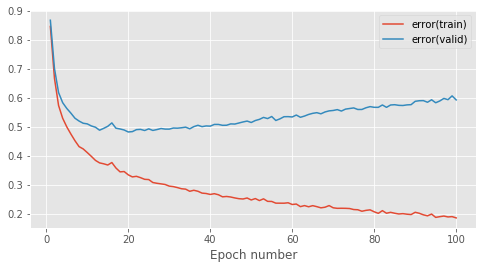

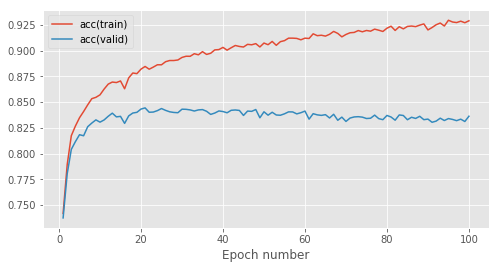

In [8]:
%load_ext autoreload
%autoreload 2
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer, ELULayer, SELULayer
from mlp.layers import BatchNormalizationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import RMSPropLearningRule,AdamLearningRule
from mlp.optimisers import Optimiser

# to ensure reproducibility of results
rng.seed(seed)

#setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate,)

experiment = 'BatchNorm_sgd_x2'

stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+'_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

### Batch normalisation with deeper DNNs

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 7.7s to complete
    error(train)=1.02e+00, acc(train)=6.76e-01, error(valid)=1.04e+00, acc(valid)=6.70e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 7.1s to complete
    error(train)=7.55e-01, acc(train)=7.48e-01, error(valid)=7.95e-01, acc(valid)=7.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 7.2s to complete
    error(train)=5.85e-01, acc(train)=8.05e-01, error(valid)=6.48e-01, acc(valid)=7.89e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 7.7s to complete
    error(train)=5.40e-01, acc(train)=8.18e-01, error(valid)=6.02e-01, acc(valid)=8.03e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 7.2s to complete
    error(train)=5.09e-01, acc(train)=8.27e-01, error(valid)=5.91e-01, acc(valid)=8.03e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 7.2s to complete
    error(train)=4.85e-01, acc(train)=8.31e-01, error(valid)=5.87e-01, acc(valid)=7.99e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 7.2s to complete
    error(train)=4.48e-01, acc(train)=8.44e-01, error(valid)=5.49e-01, acc(valid)=8.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 7.3s to complete
    error(train)=4.45e-01, acc(train)=8.46e-01, error(valid)=5.56e-01, acc(valid)=8.15e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 7.3s to complete
    error(train)=4.09e-01, acc(train)=8.55e-01, error(valid)=5.28e-01, acc(valid)=8.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 7.4s to complete
    error(train)=4.24e-01, acc(train)=8.45e-01, error(valid)=5.47e-01, acc(valid)=8.17e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 7.4s to complete
    error(train)=4.08e-01, acc(train)=8.56e-01, error(valid)=5.45e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 7.5s to complete
    error(train)=3.73e-01, acc(train)=8.65e-01, error(valid)=5.20e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 7.7s to complete
    error(train)=3.52e-01, acc(train)=8.73e-01, error(valid)=5.08e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 7.6s to complete
    error(train)=3.48e-01, acc(train)=8.73e-01, error(valid)=5.15e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 8.5s to complete
    error(train)=3.53e-01, acc(train)=8.71e-01, error(valid)=5.20e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 7.8s to complete
    error(train)=3.44e-01, acc(train)=8.74e-01, error(valid)=5.34e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 7.8s to complete
    error(train)=3.46e-01, acc(train)=8.73e-01, error(valid)=5.37e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 8.0s to complete
    error(train)=3.41e-01, acc(train)=8.75e-01, error(valid)=5.48e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 7.9s to complete
    error(train)=3.27e-01, acc(train)=8.79e-01, error(valid)=5.55e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 7.9s to complete
    error(train)=2.97e-01, acc(train)=8.88e-01, error(valid)=5.13e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 7.9s to complete
    error(train)=2.99e-01, acc(train)=8.86e-01, error(valid)=5.31e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 7.9s to complete
    error(train)=2.91e-01, acc(train)=8.90e-01, error(valid)=5.31e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 8.0s to complete
    error(train)=3.09e-01, acc(train)=8.83e-01, error(valid)=5.52e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 7.9s to complete
    error(train)=2.96e-01, acc(train)=8.86e-01, error(valid)=5.45e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 8.0s to complete
    error(train)=2.78e-01, acc(train)=8.92e-01, error(valid)=5.31e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 8.4s to complete
    error(train)=2.77e-01, acc(train)=8.95e-01, error(valid)=5.43e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 27: 8.3s to complete
    error(train)=2.83e-01, acc(train)=8.92e-01, error(valid)=5.66e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 28: 8.6s to complete
    error(train)=2.63e-01, acc(train)=8.98e-01, error(valid)=5.63e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 29: 8.7s to complete
    error(train)=2.60e-01, acc(train)=8.98e-01, error(valid)=5.48e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 30: 8.4s to complete
    error(train)=2.53e-01, acc(train)=9.02e-01, error(valid)=5.54e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 31: 8.3s to complete
    error(train)=2.51e-01, acc(train)=9.02e-01, error(valid)=5.67e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 32: 8.4s to complete
    error(train)=2.58e-01, acc(train)=9.00e-01, error(valid)=5.75e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 33: 8.3s to complete
    error(train)=2.49e-01, acc(train)=9.02e-01, error(valid)=5.72e-01, acc(valid)=8.36e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 34: 8.3s to complete
    error(train)=2.40e-01, acc(train)=9.07e-01, error(valid)=5.70e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 35: 8.4s to complete
    error(train)=2.53e-01, acc(train)=8.99e-01, error(valid)=5.95e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 36: 8.5s to complete
    error(train)=2.39e-01, acc(train)=9.05e-01, error(valid)=5.76e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 37: 8.3s to complete
    error(train)=2.26e-01, acc(train)=9.09e-01, error(valid)=5.73e-01, acc(valid)=8.40e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 38: 8.4s to complete
    error(train)=2.46e-01, acc(train)=9.04e-01, error(valid)=6.12e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 39: 8.4s to complete
    error(train)=2.42e-01, acc(train)=9.06e-01, error(valid)=6.12e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 40: 8.4s to complete
    error(train)=2.47e-01, acc(train)=9.03e-01, error(valid)=6.24e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 41: 8.4s to complete
    error(train)=2.19e-01, acc(train)=9.13e-01, error(valid)=5.81e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 42: 8.4s to complete
    error(train)=2.30e-01, acc(train)=9.09e-01, error(valid)=6.07e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 43: 8.6s to complete
    error(train)=2.41e-01, acc(train)=9.04e-01, error(valid)=6.36e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 44: 8.5s to complete
    error(train)=2.15e-01, acc(train)=9.14e-01, error(valid)=6.19e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 45: 8.7s to complete
    error(train)=2.28e-01, acc(train)=9.09e-01, error(valid)=6.28e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 46: 8.5s to complete
    error(train)=2.13e-01, acc(train)=9.15e-01, error(valid)=6.24e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 47: 8.4s to complete
    error(train)=2.13e-01, acc(train)=9.14e-01, error(valid)=6.08e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 48: 8.6s to complete
    error(train)=2.28e-01, acc(train)=9.09e-01, error(valid)=6.56e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 49: 8.6s to complete
    error(train)=2.06e-01, acc(train)=9.17e-01, error(valid)=6.12e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 50: 8.6s to complete
    error(train)=2.13e-01, acc(train)=9.14e-01, error(valid)=6.64e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 51: 8.5s to complete
    error(train)=2.07e-01, acc(train)=9.17e-01, error(valid)=6.24e-01, acc(valid)=8.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 52: 8.6s to complete
    error(train)=2.17e-01, acc(train)=9.12e-01, error(valid)=6.47e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 53: 8.5s to complete
    error(train)=2.42e-01, acc(train)=9.06e-01, error(valid)=6.95e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 54: 8.6s to complete
    error(train)=2.20e-01, acc(train)=9.12e-01, error(valid)=6.64e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 55: 9.2s to complete
    error(train)=2.24e-01, acc(train)=9.11e-01, error(valid)=6.80e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 56: 8.6s to complete
    error(train)=2.17e-01, acc(train)=9.13e-01, error(valid)=6.84e-01, acc(valid)=8.29e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 57: 8.4s to complete
    error(train)=2.16e-01, acc(train)=9.12e-01, error(valid)=6.66e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 58: 8.5s to complete
    error(train)=1.93e-01, acc(train)=9.21e-01, error(valid)=6.95e-01, acc(valid)=8.35e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 59: 8.6s to complete
    error(train)=2.06e-01, acc(train)=9.17e-01, error(valid)=6.84e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 60: 8.4s to complete
    error(train)=1.99e-01, acc(train)=9.19e-01, error(valid)=6.56e-01, acc(valid)=8.37e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 61: 8.5s to complete
    error(train)=2.21e-01, acc(train)=9.12e-01, error(valid)=7.08e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 62: 8.4s to complete
    error(train)=2.06e-01, acc(train)=9.16e-01, error(valid)=6.95e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 63: 8.4s to complete
    error(train)=2.28e-01, acc(train)=9.10e-01, error(valid)=7.47e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 64: 8.4s to complete
    error(train)=2.14e-01, acc(train)=9.14e-01, error(valid)=7.09e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 65: 9.2s to complete
    error(train)=2.22e-01, acc(train)=9.11e-01, error(valid)=7.44e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 66: 8.4s to complete
    error(train)=2.15e-01, acc(train)=9.13e-01, error(valid)=7.17e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 67: 8.5s to complete
    error(train)=1.96e-01, acc(train)=9.21e-01, error(valid)=6.99e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 68: 8.5s to complete
    error(train)=1.98e-01, acc(train)=9.20e-01, error(valid)=6.99e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 69: 8.5s to complete
    error(train)=1.88e-01, acc(train)=9.24e-01, error(valid)=7.11e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 70: 8.5s to complete
    error(train)=1.95e-01, acc(train)=9.22e-01, error(valid)=7.22e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 71: 8.6s to complete
    error(train)=1.90e-01, acc(train)=9.22e-01, error(valid)=7.31e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 72: 8.5s to complete
    error(train)=1.90e-01, acc(train)=9.23e-01, error(valid)=7.27e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 73: 8.6s to complete
    error(train)=1.80e-01, acc(train)=9.27e-01, error(valid)=7.07e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 74: 8.5s to complete
    error(train)=2.03e-01, acc(train)=9.20e-01, error(valid)=7.67e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 75: 9.3s to complete
    error(train)=1.88e-01, acc(train)=9.22e-01, error(valid)=7.03e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 76: 8.5s to complete
    error(train)=1.94e-01, acc(train)=9.22e-01, error(valid)=7.66e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 77: 8.5s to complete
    error(train)=1.88e-01, acc(train)=9.24e-01, error(valid)=7.73e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 78: 8.6s to complete
    error(train)=1.90e-01, acc(train)=9.23e-01, error(valid)=7.61e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 79: 8.7s to complete
    error(train)=2.03e-01, acc(train)=9.19e-01, error(valid)=7.74e-01, acc(valid)=8.28e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 80: 8.5s to complete
    error(train)=1.91e-01, acc(train)=9.23e-01, error(valid)=7.61e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 81: 8.6s to complete
    error(train)=1.82e-01, acc(train)=9.27e-01, error(valid)=7.75e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 82: 8.7s to complete
    error(train)=1.79e-01, acc(train)=9.27e-01, error(valid)=7.95e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 83: 8.7s to complete
    error(train)=2.13e-01, acc(train)=9.17e-01, error(valid)=8.14e-01, acc(valid)=8.25e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 84: 8.7s to complete
    error(train)=1.79e-01, acc(train)=9.28e-01, error(valid)=7.29e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 85: 9.2s to complete
    error(train)=1.68e-01, acc(train)=9.31e-01, error(valid)=7.48e-01, acc(valid)=8.32e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 86: 8.7s to complete
    error(train)=2.00e-01, acc(train)=9.19e-01, error(valid)=7.66e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 87: 8.8s to complete
    error(train)=1.77e-01, acc(train)=9.29e-01, error(valid)=7.62e-01, acc(valid)=8.34e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 88: 8.9s to complete
    error(train)=1.79e-01, acc(train)=9.26e-01, error(valid)=7.45e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 89: 8.9s to complete
    error(train)=1.85e-01, acc(train)=9.24e-01, error(valid)=7.96e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 90: 8.6s to complete
    error(train)=2.11e-01, acc(train)=9.18e-01, error(valid)=7.97e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 91: 8.7s to complete
    error(train)=1.65e-01, acc(train)=9.32e-01, error(valid)=7.78e-01, acc(valid)=8.33e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 92: 8.7s to complete
    error(train)=1.62e-01, acc(train)=9.33e-01, error(valid)=8.13e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 93: 8.8s to complete
    error(train)=1.75e-01, acc(train)=9.28e-01, error(valid)=7.93e-01, acc(valid)=8.27e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 94: 9.1s to complete
    error(train)=1.69e-01, acc(train)=9.30e-01, error(valid)=7.92e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 95: 8.8s to complete
    error(train)=1.73e-01, acc(train)=9.30e-01, error(valid)=8.32e-01, acc(valid)=8.31e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 96: 8.7s to complete
    error(train)=1.88e-01, acc(train)=9.25e-01, error(valid)=8.49e-01, acc(valid)=8.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 97: 8.8s to complete
    error(train)=1.85e-01, acc(train)=9.26e-01, error(valid)=8.06e-01, acc(valid)=8.30e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 98: 8.7s to complete
    error(train)=1.94e-01, acc(train)=9.21e-01, error(valid)=8.13e-01, acc(valid)=8.23e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 99: 8.7s to complete
    error(train)=1.90e-01, acc(train)=9.24e-01, error(valid)=8.25e-01, acc(valid)=8.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 100: 8.6s to complete
    error(train)=1.73e-01, acc(train)=9.29e-01, error(valid)=7.83e-01, acc(valid)=8.27e-01



Experiment Re_x7 best acc at Epoch=37 by parameter=0.1

error(train)= 0.22552304119054734, error(valid)=0.5725763959387028, 
 error gap = 0.34705335474815546,  acc(valid)=0.8402531645569618

Smallest error gap(after best acc epoch) = 0.34705335474815546 at Epoch=37


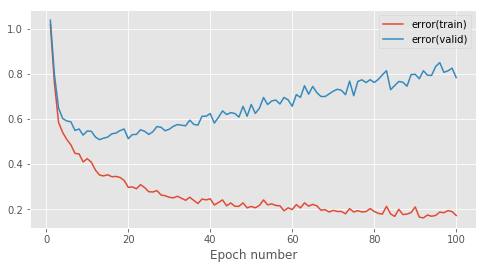

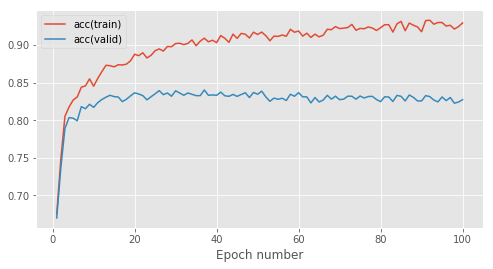

In [11]:
######################################################################################################
# Deeper DNNs without Batch normalisation 
######################################################################################################
# to ensure reproducibility of results
rng.seed(seed)

#setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate, )

experiment = 'Re_x7'

optimiser, stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+ '_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

In [10]:
######################################################################################################
# Batch normalisation with deeper DNNs
######################################################################################################
# to ensure reproducibility of results
rng.seed(seed)

#setup hyperparameters
learning_rate = 0.1
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    BatchNormalizationLayer(hidden_dim),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate, )

experiment = 'BN_x7'

optimiser, stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+ '_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

Experiment BN_x7 best acc at Epoch=49 by parameter=0.1

error(train)= 0.21631500725730898, error(valid)=0.4699329569805209, 
 error gap = 0.25361794972321194,  acc(valid)=0.8541139240506328

Smallest error gap(after best acc epoch) = 0.25361794972321194 at Epoch=49


In [52]:
#save_stats['BatchNorm_before_relu_sgd_x2']=save_stats['BatchNorm_sgd_x2']
#save_stats['BatchNorm_after_Relu_sgd_x2']=save_stats['BatchNorm_after_Relu_x2']

for n,e in zip( [], ['Relu_x2','BatchNorm_sgd_x2', 'RMSProp_hidden100_x2','Adam_hidden100_x2'] ):
    save_stats[n] = np.loadtxt(e +'.csv', delimiter=',')
save_stats.keys()


dict_keys(['BN_x7', 'Re_x7', 'Relu_L2Penal_1e-4_x2', 'Relu_L2Penal_1e-3_x2', 'Drop_x2', 'Relu_x2', 'BatchNorm_sgd_x2', 'RMSProp_hidden100_x2', 'Adam_hidden100_x2'])

### Plot Batch Norm impact

D:\Anaconda3\envs\mlp\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


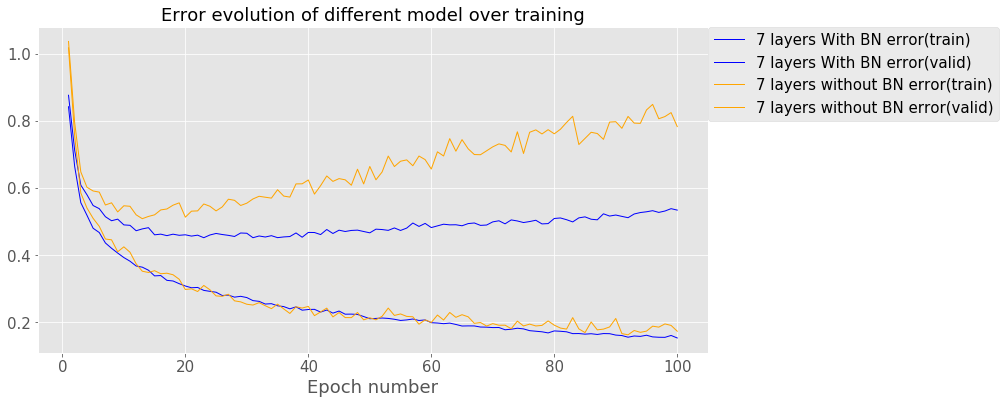

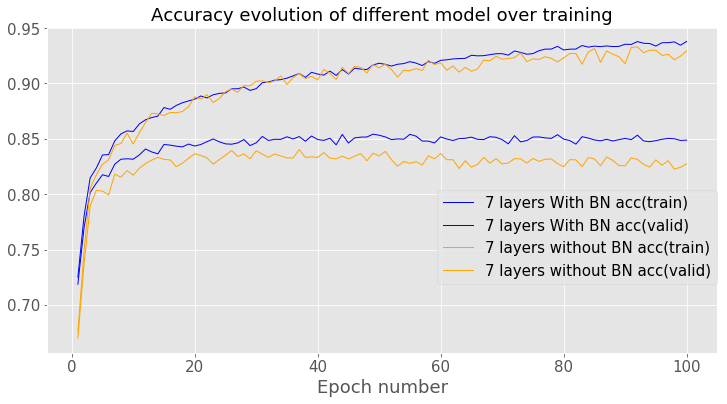

In [57]:
# Plot comparison
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
######################################################################################################
color = ['b', 'orange', 'g', 'r', 'm', 'gray', 'y',] 
#experiments = ('Relu_x2', 'Relu_L2Penal_1e-4_x2', 'Relu_L2Penal_1e-3_x2', 'Drop_x2', 'BatchNorm_before_relu_sgd_x2')
experiments = ( 'BN_x7', 'Re_x7',)
list_name = ( '7 layers With BN', '7 layers without BN',)
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(12 , 6))
ax_1 = fig_1.add_subplot(111)

for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(list_name[i]+' '+k), color = color[i], linewidth=1)

ax_1.legend(bbox_to_anchor=(1., 1), loc=0, borderaxespad=0.)
ax_1.set_xlabel('Epoch number')
plt.title('Error evolution of different model over training',fontsize=18)
        
# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(12, 6))
ax_2 = fig_2.add_subplot(111)
        
for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(list_name[i]+' '+k), color = color[i], linewidth=1)

ax_2.legend(bbox_to_anchor=(1., 0.5), loc=0, borderaxespad=0.)
ax_2.set_xlabel('Epoch number')
plt.title('Accuracy evolution of different model over training',fontsize=18)

fig_1.savefig('BN_impact_DNN_error.pdf',bbox_inches = "tight")
fig_2.savefig('BN_impact_DNN_accuracy.pdf',bbox_inches = "tight" )

### Construct more complicated model to get a higher performance

Drop out, Adam learning rule

In [ ]:
from mlp.layers import DropoutLayer
rng.seed(seed)

#setup hyperparameters
learning_rate = 0.01
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 256
##########################################################
# Use p = 0.5 in hidden layers and 0.8 in the input layer.
incl_prob_0 =0.8
incl_prob = 0.5
# n/p
hidden_dim = int(hidden_dim/incl_prob)
mom_coeff = 0.95
##########################################################
weights_penalty = L2Penalty(1e-3)
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)
model = MultipleLayerModel([
    DropoutLayer(rng, incl_prob_0),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    #DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate, beta1=mom_coeff)

experiment = 'Drop_re_Drop'

optimiser, stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)
fig_1.savefig(experiment+ '_learning_rate_{}_error.pdf'.format(learning_rate))
fig_2.savefig(experiment+ '_learning_rate_{}_accuracy.pdf'.format(learning_rate))

save_and_present(experiment, stats, learning_rate)

save_stats[experiment] = stats

save_results[experiment] = optimiser.eval_monitors(test_data, 'test')
print('Test error:    ' + str(save_results[experiment]['errortest']))
print('Test accuracy: ' + str(save_results[experiment]['acctest']))


HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 1: 63.0s to complete
    error(train)=2.56e+00, acc(train)=2.41e-01, error(valid)=2.57e+00, acc(valid)=2.39e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 2: 60.3s to complete
    error(train)=2.09e+00, acc(train)=3.63e-01, error(valid)=2.10e+00, acc(valid)=3.59e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 3: 61.7s to complete
    error(train)=1.80e+00, acc(train)=4.54e-01, error(valid)=1.81e+00, acc(valid)=4.42e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 4: 62.9s to complete
    error(train)=1.60e+00, acc(train)=5.06e-01, error(valid)=1.61e+00, acc(valid)=5.04e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 5: 27981.9s to complete
    error(train)=1.53e+00, acc(train)=5.29e-01, error(valid)=1.55e+00, acc(valid)=5.24e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 6: 59.9s to complete
    error(train)=1.45e+00, acc(train)=5.53e-01, error(valid)=1.48e+00, acc(valid)=5.49e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 7: 60.4s to complete
    error(train)=1.43e+00, acc(train)=5.61e-01, error(valid)=1.45e+00, acc(valid)=5.54e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 8: 61.4s to complete
    error(train)=1.33e+00, acc(train)=5.85e-01, error(valid)=1.37e+00, acc(valid)=5.80e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 9: 59.7s to complete
    error(train)=1.33e+00, acc(train)=5.92e-01, error(valid)=1.36e+00, acc(valid)=5.91e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 10: 60.7s to complete
    error(train)=1.29e+00, acc(train)=6.08e-01, error(valid)=1.33e+00, acc(valid)=5.97e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 11: 59.4s to complete
    error(train)=1.26e+00, acc(train)=6.05e-01, error(valid)=1.30e+00, acc(valid)=5.99e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 12: 59.7s to complete
    error(train)=1.23e+00, acc(train)=6.14e-01, error(valid)=1.27e+00, acc(valid)=6.06e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 13: 60.8s to complete
    error(train)=1.23e+00, acc(train)=6.15e-01, error(valid)=1.27e+00, acc(valid)=6.05e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 14: 86.1s to complete
    error(train)=1.21e+00, acc(train)=6.23e-01, error(valid)=1.25e+00, acc(valid)=6.18e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 15: 96.2s to complete
    error(train)=1.24e+00, acc(train)=6.16e-01, error(valid)=1.28e+00, acc(valid)=6.10e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 16: 90.8s to complete
    error(train)=1.19e+00, acc(train)=6.30e-01, error(valid)=1.24e+00, acc(valid)=6.21e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 17: 90.8s to complete
    error(train)=1.21e+00, acc(train)=6.24e-01, error(valid)=1.27e+00, acc(valid)=6.13e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 18: 91.1s to complete
    error(train)=1.22e+00, acc(train)=6.22e-01, error(valid)=1.29e+00, acc(valid)=6.08e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 19: 93.6s to complete
    error(train)=1.17e+00, acc(train)=6.35e-01, error(valid)=1.23e+00, acc(valid)=6.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 20: 92.8s to complete
    error(train)=1.22e+00, acc(train)=6.14e-01, error(valid)=1.28e+00, acc(valid)=6.03e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 21: 92.4s to complete
    error(train)=1.24e+00, acc(train)=6.19e-01, error(valid)=1.29e+00, acc(valid)=6.11e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 22: 93.5s to complete
    error(train)=1.20e+00, acc(train)=6.27e-01, error(valid)=1.26e+00, acc(valid)=6.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 23: 92.7s to complete
    error(train)=1.21e+00, acc(train)=6.20e-01, error(valid)=1.29e+00, acc(valid)=6.07e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 24: 92.9s to complete
    error(train)=1.17e+00, acc(train)=6.36e-01, error(valid)=1.23e+00, acc(valid)=6.26e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 25: 92.9s to complete
    error(train)=1.19e+00, acc(train)=6.34e-01, error(valid)=1.24e+00, acc(valid)=6.22e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Epoch 26: 93.5s to complete
    error(train)=1.19e+00, acc(train)=6.20e-01, error(valid)=1.26e+00, acc(valid)=6.12e-01


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

D:\Anaconda3\envs\mlp\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


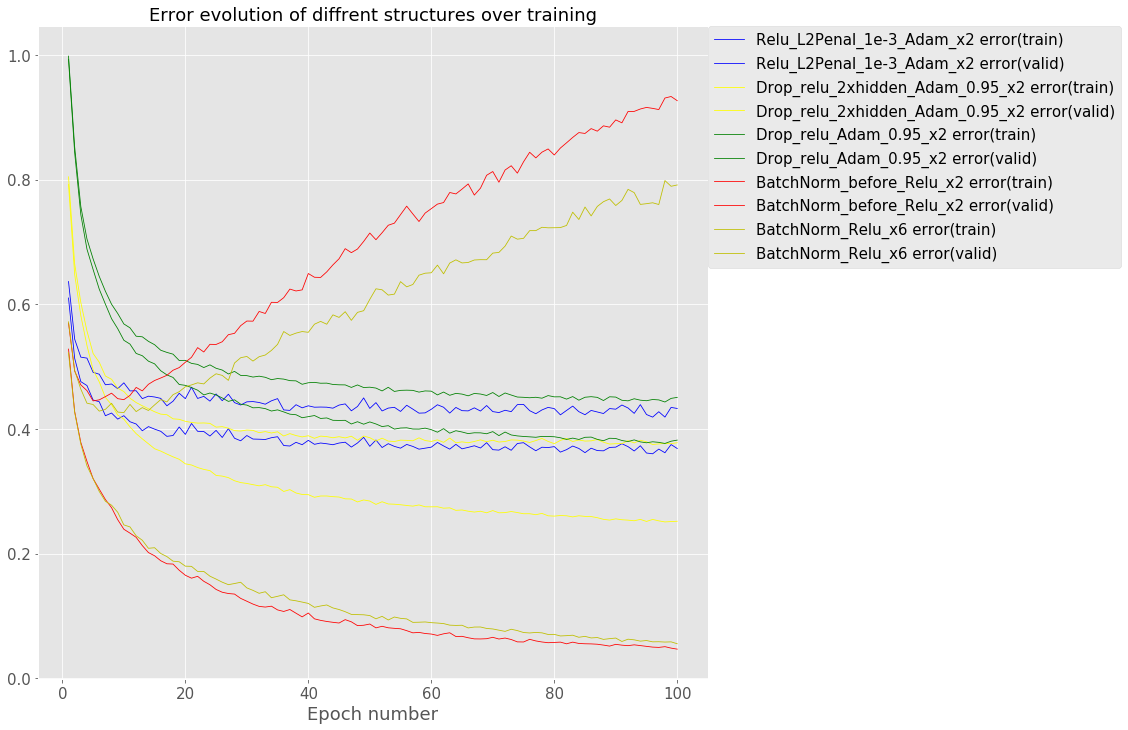

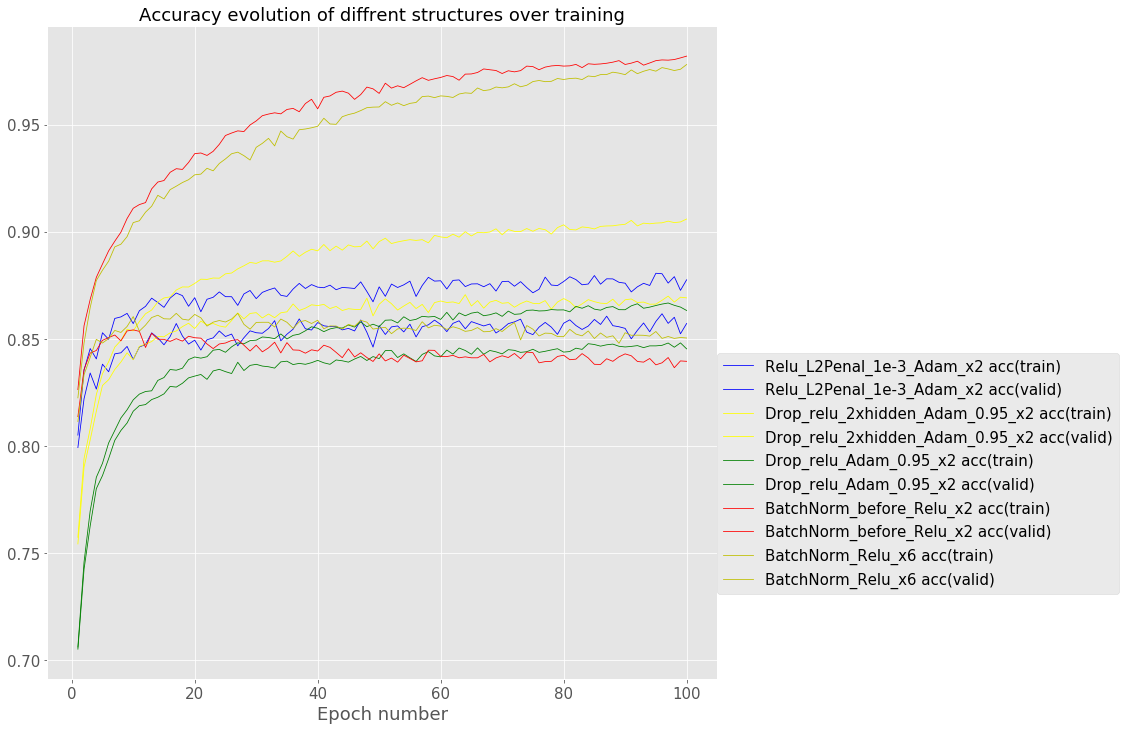

In [33]:
######################################################################################################
# Plot complicated model
######################################################################################################
# Plot comparison
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
color = ['b', 'yellow', 'g', 'r', 'y', 'm', 'gray',]
experiments = ( 'Relu_L2Penal_1e-3_Adam_x2', 'Drop_relu_2xhidden_Adam_0.95_x2', 'Drop_relu_Adam_0.95_x2', 'BatchNorm_before_Relu_x2',
                'BatchNorm_Relu_x6') 

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(12 , 12))
ax_1 = fig_1.add_subplot(111)

for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(experiments[i]+' '+k), color=color[i] , linewidth=0.8)
    
ax_1.legend(bbox_to_anchor=(1., 1), loc=0, borderaxespad=0.)
ax_1.set_xlabel('Epoch number')
plt.title('Error evolution of diffrent structures over training',fontsize=18)

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(12, 12))
ax_2 = fig_2.add_subplot(111)
for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(experiments[i]+' '+k), color=color[i] , linewidth=0.8)

        ax_2.legend(bbox_to_anchor=(1., 0.5), loc=0, borderaxespad=0.)
ax_2.set_xlabel('Epoch number')
plt.title('Accuracy evolution of diffrent structures over training',fontsize=18)

fig_1.savefig('Error_structures.pdf',bbox_inches = "tight")
fig_2.savefig('Accuracy_structures.pdf',bbox_inches = "tight" )

### Plot Batch Norm impact

D:\Anaconda3\envs\mlp\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


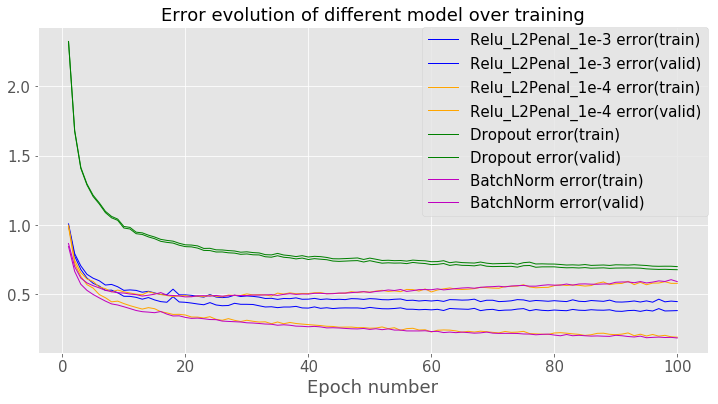

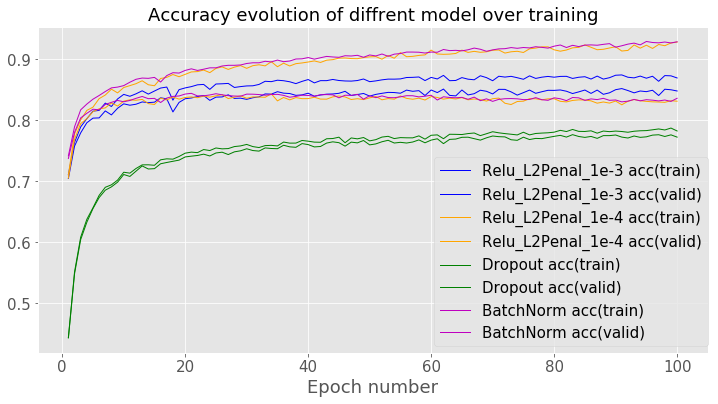

In [43]:
# Plot comparison
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
color = ['b', 'orange', 'g', 'm', 'r', 'gray', 'y',] 
experiments = ( 'Relu_L2Penal_1e-3_x2', 'Relu_L2Penal_1e-4_x2','Drop_x2', 'BatchNorm_sgd_x2', )
list_name = ( 'Relu_L2Penal_1e-3', 'Relu_L2Penal_1e-4','Dropout', 'BatchNorm',)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(12 , 6))
ax_1 = fig_1.add_subplot(111)

for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(list_name[i]+' '+k), color=color[i], linewidth= 1)
ax_1.legend(bbox_to_anchor=(1., 1), loc=0, borderaxespad=0.)
ax_1.set_xlabel('Epoch number')
plt.title('Error evolution of different model over training',fontsize=18)

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(12, 6))
ax_2 = fig_2.add_subplot(111)        
for i, experiment in enumerate(experiments):
    s = save_stats[experiment]
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, s.shape[0]) * stats_interval,
              s[1:, keys[k]], label=str(list_name[i]+' '+k), color=color[i], linewidth= 1)

ax_2.legend(bbox_to_anchor=(1., 0.6), loc=0, borderaxespad=0.)
ax_2.set_xlabel('Epoch number')
plt.title('Accuracy evolution of diffrent model over training',fontsize=18)

fig_1.savefig('Regularization_Error.pdf',bbox_inches = "tight")
fig_2.savefig('Regularization_Accuracy.pdf',bbox_inches = "tight" )

D:\Anaconda3\envs\mlp\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


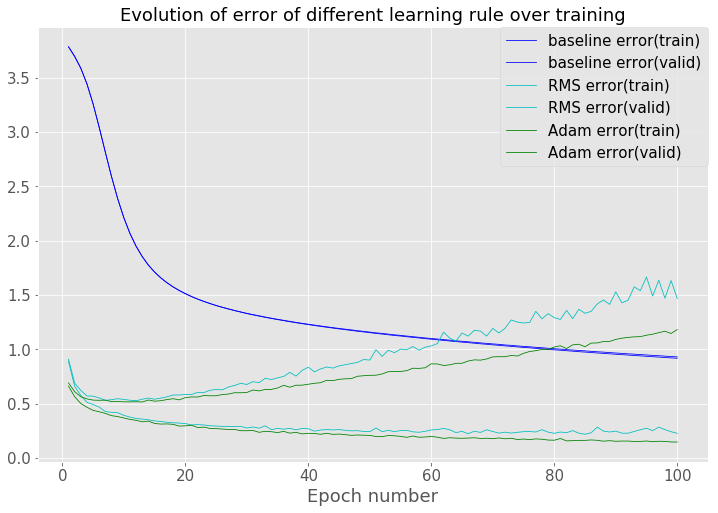

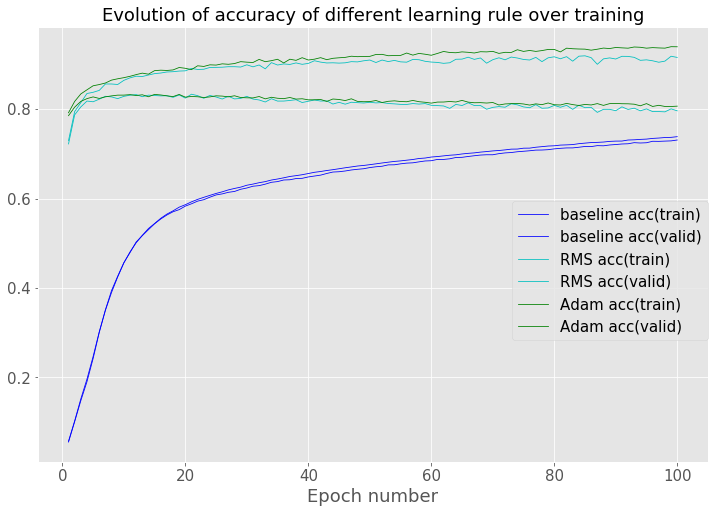

In [27]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

# Plot the change in the validation and training set error over training.
fig_1_comp = plt.figure(figsize=(12 , 8))
color = ['b', 'c','g', 'r', 'y']

plot_list = [stats, stats_rms, stats_adam]
plot_list_name = ['baseline','RMS','Adam']
ax_1 = fig_1_comp.add_subplot(111)

for i,s in enumerate(plot_list):#,stats_ELU_4,stats_ELU_5,stats_ELU_6,stats_ELU_7,stats_ELU_8]:
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, s.shape[0]) * stats_interval, 
              s[1:, keys[k]], label=str(plot_list_name[i]+' '+k),color=color[i],linewidth=0.8)

ax_1.legend(bbox_to_anchor=(1., 1), loc=0, borderaxespad=0.)
ax_1.set_xlabel('Epoch number')
plt.title('Evolution of error of different learning rule over training',fontsize=18)

# Plot the change in the validation and training set accuracy over training.
fig_2_comp = plt.figure(figsize=(12, 8))
ax_2 = fig_2_comp.add_subplot(111)
for i,s in enumerate(plot_list):
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, s.shape[0]) * stats_interval, 
              s[1:, keys[k]], label=str(plot_list_name[i]+' '+k),color=color[i],linewidth=0.8)
ax_2.legend(bbox_to_anchor=(1., 0.6), loc=0, borderaxespad=0.)
ax_2.set_xlabel('Epoch number')
plt.title('Evolution of accuracy of different learning rule over training',fontsize=18)

fig_1_comp.savefig('error_comp_learningrule.pdf',bbox_inches = "tight")
fig_2_comp.savefig('accuracy_comp_learningrule.pdf',bbox_inches = "tight" )